# Lilbraries & functions

In [1]:
import numpy as np
import pandas as pd
import pyBigWig as bw

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from mpl_toolkits.mplot3d import art3d
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

import pandas as pd
import seaborn as sns
import threading
print(threading.active_count(), 'threads active at start')

%load_ext autoreload
%autoreload 2
%reload_ext autoreload
from KalmanFilter import KalmanFilter, KalmanFilter_rotating_Q, KalmanFilter_k_hidden

# vectorized version
def hsv_to_rgb_v( h, s, v) -> tuple:
    
    out = np.full([h.shape[0],3], np.nan)
    idx_na = np.isnan(h) | np.isnan(s) | np.isnan(v)
    out[idx_na,:] = np.array([1,1,1]).T

    out_tmp = np.full([np.sum(~idx_na),3], np.nan)
    h = h[~idx_na]
    s = s[~idx_na]
    v = v[~idx_na]

    h[h==1.0] = 0.0
    i = (h*6.0).astype(int)
    f = h*6.0 - i
        
    w = v * (1.0 - s)
    q = v * (1.0 - s * f)
    t = v * (1.0 - s * (1.0 - f))

    i[s==0] = -1

    out_tmp[i==0,:] = np.array([v[i==0],t[i==0],w[i==0]]).T
    out_tmp[i==1,:] = np.array([q[i==1],v[i==1],w[i==1]]).T
    out_tmp[i==2,:] = np.array([w[i==2],v[i==2],t[i==2]]).T
    out_tmp[i==3,:] = np.array([w[i==3],q[i==3],v[i==3]]).T
    out_tmp[i==4,:] = np.array([t[i==4],w[i==4],v[i==4]]).T
    out_tmp[i==5,:] = np.array([v[i==5],w[i==5],q[i==5]]).T
    out_tmp[i==-1,:] = np.array([v[i==-1],v[i==-1],v[i==-1]]).T

    out[~idx_na,:] = out_tmp

    return out

7 threads active at start


/tmp/ipykernel_3734/1560711055.py:2: DeprecationWarning: activeCount() is deprecated, use active_count() instead
  threading.activeCount()


7

# Toy example

loglik =  -2979.3884202223703


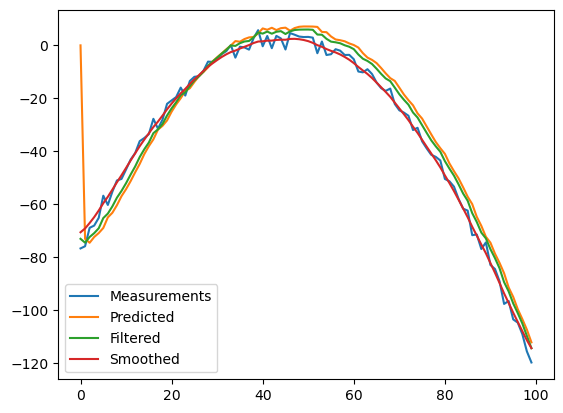

In [2]:
dt = 1.0/60
F = np.array([[1, dt, 0], [0, 1, dt], [0, 0, 1]])
H = np.array([1, 0, 0]).reshape(1, 3)
Q = np.array([[0.05, 0.05, 0.0], [0.05, 0.05, 0.0], [0.0, 0.0, 0.0]])
R = np.array([0.5]).reshape(1, 1)

x = np.linspace(-10, 10, 100)
measurements = - (x**2 + 2*x - 2)  + np.random.normal(0, 2, 100)

kf = KalmanFilter(F = F, H = H, Q = Q, R = R, μ_0 = np.array([0,0,0]), Σ_0 = np.eye(3)*10)

predicted = []
filtered = []
for z in measurements:
    predicted.append(np.dot(H,  kf.predict()[0]))
    filtered.append(np.dot(H,  kf.update(z)[0]))

plt.plot(range(len(measurements)), measurements, label = 'Measurements')
plt.plot(range(len(predicted)), np.array(predicted), label = 'Predicted')
plt.plot(range(len(filtered)), np.array(filtered), label = 'Filtered')

#test Forward-Backward
forward_table, ll = kf.fullForward(measurements)
print('loglik = ', ll)

smoothed = kf.Backward(forward_table,F)[0]
s=(H[:,None,:] * np.array(smoothed)[None,:,:]).sum(axis=2).squeeze()
plt.plot(range(len(measurements)), s, label = 'Smoothed')
plt.legend()
plt.show()


# PROseq

## Get dataset

1


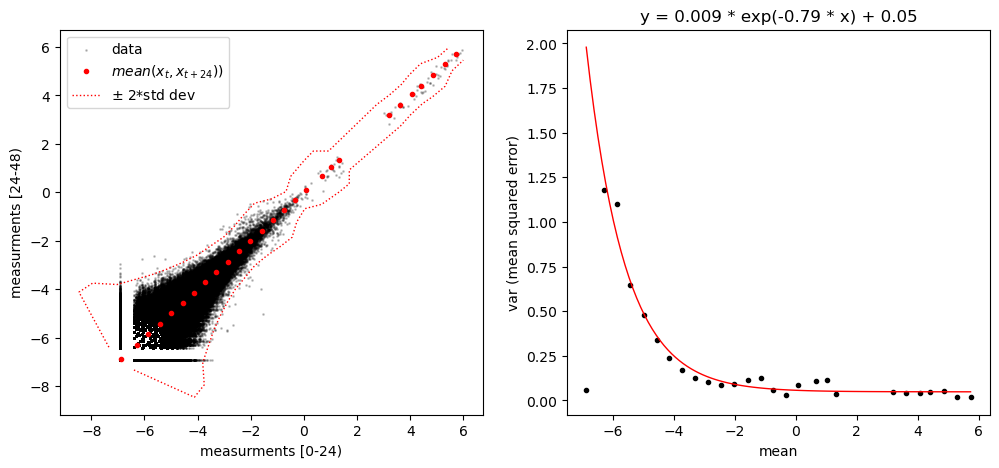

In [17]:
# Parameters
bw_path = '../results/binned_norm_counts'
bin_size = 1000 # bp
Strands = ['forward', 'reverse']
strand_dict = {'forward':'+', 'reverse':'-', '+':'forward', '-':'reverse'}

chr = 'chr17'

df = pd.read_csv(f'{bw_path}/NormCoverage_3p_bin{bin_size}bp_{chr}.csv',index_col=0,sep='\t')

# remove rows with 8 or more NaNs (out of 12)
#df = df[strand].dropna(thresh=2+len(T)-8)

# replace missing values with 0, add pseudocount, take the log
df.fillna(0,inplace=True)
df = df.apply(lambda x: np.log(x+1/bin_size),axis=1)

# get predicted values
# df_pred = pd.read_csv(f'../results/phase_amp/bin_phase_amp_{bin_size}bp.csv',index_col=0)

# get overall phase and amplitude
df_overall = pd.read_csv(f'../results/phase_amp/overall_phase_amp_{bin_size}bp.csv',index_col=0,sep='\t')
r_genome = df_overall.amplitude.values
φ_genome = df_overall.phase.values
a_genome = r_genome * np.cos(φ_genome)
b_genome = r_genome * np.sin(φ_genome)
μ_genome = a_genome + 1j*b_genome

del df_overall, r_genome, φ_genome, a_genome, b_genome

# estimate R

# get mesurments at time [0-24) and [24-48) 
x = df.loc[:,[f"{t}{s}" for t in np.arange(0 ,24,4) for s in ['+', '-']]].values.flatten()
y = df.loc[:,[f"{t}{s}" for t in np.arange(24,48,4) for s in ['+', '-']]].values.flatten()
df_err = pd.DataFrame({'x':x,'y':y})

# estimate error as the difference between the two measurements
df_err['err'] = (df_err.x - df_err.y)**2
df_err['m'] = (df_err.x + df_err.y)/2
df_err['m_bin'] = pd.cut(df_err.m,30)
df_err = df_err.groupby(['m_bin']).agg({'x':'mean','y':'mean','m':'mean','err':'mean'}).reset_index()
# remove nan rows
df_err = df_err.loc[~df_err.isna().any(axis=1),:]

# exponential fit
from scipy.optimize import curve_fit
def func(x, a, λ, c):
    return a * np.exp(-λ * x) + c

x0 = np.argmax(df_err['err'].values)
print(x0)
popt, pcov = curve_fit(func, df_err['m'][x0:], df_err['err'][x0:], p0=[1, 0.1, 0.1])

#def func(x, x0, a, c):
#    return a/(x-x0) + c
#popt, pcov = curve_fit(func, df_err['m'][1:], df_err['err'][1:], p0=[df_err['m'][0], 0.1, 0.1])


fig, axes = plt.subplots(1,2,figsize=(12,5))

ax = axes[0]
ax.scatter(x,y,s=1,c='k',alpha=.2)
ax.plot(df_err.m,df_err.m,'r.',lw=2)
ax.plot(df_err.m - 2*np.sqrt(df_err['err']),df_err.m + 2*np.sqrt(df_err['err']),'r:',lw=1)
ax.plot(df_err.m + 2*np.sqrt(df_err['err']),df_err.m - 2*np.sqrt(df_err['err']),'r:',lw=1)
ax.set_xlabel('measurments [0-24)')
ax.set_ylabel('measurments [24-48)')
ax.legend(['data','$mean(x_t,x_{t+24})$)',r'$\pm$ 2*std dev'])

ax = axes[1]
ax.plot(df_err['m'],df_err['err'],'k.',lw=1)
_x = np.linspace(df_err['m'].min(),df_err['m'].max(),100)
ax.plot(_x, func(_x, *popt), 'r-',lw=1)
ax.title.set_text(f"y = {popt[0]:.3f} * exp(-{popt[1]:.2f} * x) + {popt[2]:.2f}")
ax.set_xlabel('mean')
ax.set_ylabel('var (mean squared error)')
#ax.set_yscale('log')


R_a = popt[0]
R_b = popt[1]
R_c = popt[2]



In [14]:
df.to_csv(f'../results/{chr}_{bin_size}bp.csv',sep='\t',index=True)

In [18]:
df

0+        4+        8+       12+       16+       20+  \
pos                                                                    
3056500  -6.907755 -6.907755 -6.907755 -6.907755 -6.907755 -6.907755   
3057500  -6.907755 -6.907755 -6.907755 -6.907755 -6.907755 -6.907755   
3058500  -6.907755 -6.907755 -6.907755 -6.907755 -6.907755 -6.907755   
3059500  -6.907755 -6.907755 -6.907755 -6.907755 -6.907755 -6.907755   
3060500  -6.907755 -6.907755 -6.907755 -6.907755 -6.907755 -6.907755   
...            ...       ...       ...       ...       ...       ...   
95188500 -5.280515 -5.423053 -5.820967 -6.336911 -5.842436 -5.369300   
95189500 -6.907755 -6.907755 -6.223463 -5.711025 -6.907755 -6.110640   
95191500 -6.047709 -6.907755 -6.907755 -6.907755 -6.907755 -6.907755   
95192500 -6.907755 -6.907755 -6.907755 -6.907755 -6.907755 -6.907755   
95193500 -6.047709 -6.907755 -6.907755 -5.711024 -6.907755 -6.907755   

               24+       28+       32+       36+  ...        8-       12-  \
pos                                               ...                       
3056500  -6.907755 -6.907755 -6.907755 -6.907755  ... -6.907755 -6.907755   
3057500  -6.907755 -6.907755 -6.907755 -6.907755  ... -6.056370 -6.907755   
3058500  -6.907755 -6.907755 -6.907755 -6.907755  ... -6.907755 -6.907755   
3059500  -6.907755 -6.907755 -6.907755 -6.907755  ... -6.907755 -5.464438   
3060500  -6.907755 -6.907755 -6.907755 -6.907755  ... -5.603273 -6.907755   
...            ...       ...       ...       ...  ...       ...       ...   
95188500 -5.016810 -6.377061 -4.962794 -6.907755  ... -5.603270 -6.907755   
95189500 -5.680755 -5.403553 -6.907755 -6.907755  ... -5.055911 -5.758298   
95191500 -6.907755 -6.907755 -6.907755 -6.907755  ... -6.907755 -6.907755   
95192500 -6.907755 -6.377061 -6.907755 -6.907755  ... -6.907755 -6.907755   
95193500 -6.317936 -6.377061 -6.907755 -6.907755  ... -6.907755 -6.907755   

               16-       20-       24-       28-       32-       36-  \
pos                                                                    
3056500  -6.907755 -6.907755 -6.907755 -6.907755 -6.907755 -6.907755   
3057500  -6.907755 -6.907755 -6.907755 -6.907755 -6.907755 -6.907755   
3058500  -6.907755 -6.907755 -6.907755 -6.907755 -6.907755 -6.907755   
3059500  -5.328474 -6.907755 -6.907755 -6.907755 -6.907755 -6.907755   
3060500  -6.907755 -6.907755 -6.907755 -6.245356 -6.907755 -6.907755   
...            ...       ...       ...       ...       ...       ...   
95188500 -5.635851 -6.907755 -6.201702 -6.907755 -5.423951 -6.907755   
95189500 -5.635851 -4.724370 -5.277746 -5.347978 -4.715438 -6.907755   
95191500 -6.907755 -6.907755 -6.907755 -6.907755 -6.907755 -6.907755   
95192500 -6.907755 -6.907755 -6.907755 -6.907755 -6.907755 -6.907755   
95193500 -6.907755 -6.907755 -6.201702 -6.907755 -6.907755 -6.907755   

               40-       44-  
pos                           
3056500  -6.907755 -5.685829  
3057500  -6.907755 -5.953857  
3058500  -6.907755 -5.474668  
3059500  -6.907755 -6.321133  
3060500  -6.907755 -5.953857  
...            ...       ...  
95188500 -6.907755 -6.321133  
95189500 -6.042009 -5.474668  
95191500 -6.907755 -6.907755  
95192500 -6.907755 -6.907755  
95193500 -6.907755 -6.321133  

[54305 rows x 24 columns]

## Kalman filtering and smoothing

### Plots

In [19]:
def plot_log_likelihood(LL,K):
    
    # find the maximum
    x_max = LL.argmax()
    y_max = LL.max()
    k_max = K[x_max]
    λ_max = 2*np.pi/k_max
    
    fig, axes = plt.subplots(1,2,figsize=(8,4),sharey=True,gridspec_kw={'wspace':0})

    ax = axes[0]
    ax.plot(-K[K<0],np.exp(LL[K<0]-max(LL)),'k.-')
    if K[x_max] < 0:
        ax.plot(-K[x_max],np.exp(y_max-max(LL)),'r.')

    zero = ax.get_xlim()[0]
    ax.plot(zero,np.exp(LL[K==0]-max(LL)),'o',color='k')

    # inverse x axis
    ax.invert_xaxis()
    ax.set_xlabel(r'K')
    ax.set_ylabel('Log-likelihood')
    ax.set_title(rf'max LL at $\lambda$={λ_max/1e3:.2f}kb')
    ax.set_xscale('log')

    ax = axes[1]
    ax.plot(K[K>0],np.exp(LL[K>0]-max(LL)),'k.-')
    if K[x_max] > 0:
        ax.plot(K[x_max],np.exp(y_max-max(LL)),'r.')
    
    zero = ax.get_xlim()[0]
    ax.plot(zero,np.exp(LL[K==0]-max(LL)),'o',color='gray')

    yticklabels = ax.get_yticklabels()
    ax.set_yticklabels([f'-{y}' for y in yticklabels])
    ax.set_xlabel(r'K')
    ax.set_title(rf'max LL at $k$={k_max/(2*np.pi)*1e6:.2f}Mb$^{{-1}}$')
    ax.set_xscale('log')
    
    fig.tight_layout()
    #fig.subplots_adjust(wspace=0)

def plot_scatter_phi_a(φ_n,φ_kf,a_n,a_kf):
    # put phi_kf - phi_n between -pi and pi
    idx_tl = (φ_kf - φ_n) > np.pi
    idx_br = (φ_n - φ_kf) > np.pi
    idx_tr = (φ_n + φ_kf) > 2*np.pi
    idx_bl = (φ_n + φ_kf) < 2*np.pi
    φ_n[idx_tl & idx_bl] += 2*np.pi
    φ_kf[idx_tl & idx_tr] -= 2*np.pi
    φ_kf[idx_br & idx_bl] += 2*np.pi
    φ_n[idx_br & idx_tr] -= 2*np.pi

    alpha = a_kf/a_kf.mean()
    alpha[alpha>1] = 1

    fig = plt.figure(figsize=(8,4))
    plt.subplot(121)
    plt.plot([0,2*np.pi],[0,2*np.pi],'k--',lw=1)
    plt.scatter(φ_n,φ_kf,s=3,marker='.',alpha=alpha)
    plt.xlabel('φ_n')
    plt.ylabel('φ_kf')

    plt.subplot(122)
    plt.scatter(a_n,a_kf,s=3,marker='.')
    plt.xlabel('a_n')
    plt.ylabel('a_kf')

    fig.tight_layout()

def plot_phase_per_bin(x,f_n,μ_tT_best_C,φ_n,φ_kf,a_n,a_kf,Σ_tT_best,tube=False):

    # phase/amp to color
    h = φ_n/(2*np.pi)
    s = a_n/np.nanmax(a_n)
    v = np.ones(len(x))
    color_f = hsv_to_rgb_v(h,s,v)
    f_n[np.isnan(f_n)] = 0

    h = φ_kf/(2*np.pi)
    s = a_kf/a_kf.mean()
    s[s>1] = 1
    v = np.ones(len(x))
    color_kf = hsv_to_rgb_v(h,s,v)

    # plot phase per bin
    Φ = np.ones((2,len(x),3))
    Φ[0,:] = color_f
    Φ[1,:] = color_kf
    fig = plt.figure(figsize=(30,1))
    plt.imshow(Φ,aspect='auto',interpolation='none')

    # plot amp and phase per bin in 3D
    fig = plt.figure(figsize=(20,20))
    for f,azim in enumerate( range(30,360,90) ):
        ax = fig.add_subplot(2,2,f+1, projection='3d')
        ax.scatter(xs=f_n.real, ys=f_n.imag, zs=x, color=Φ[0,:],s=5,marker='o')

        Re = μ_tT_best_C.real
        Im = μ_tT_best_C.imag
        ax.scatter(xs=Re, ys=Im, zs=x, color='k',s=1,marker='.',alpha=.2)
        if tube:
            for i in range(len(x)):
                cov = Σ_tT_best[i]
                pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
                ell_radius_x = np.sqrt(1 + pearson)
                ell_radius_y = np.sqrt(1 - pearson)
                ell = Ellipse((Re[i], Im[i]), width=ell_radius_x * 2, height=ell_radius_y * 2,facecolor='none',edgecolor='k',angle=45,alpha=.1)
                ax.add_patch(ell)
                pathpatch_2d_to_3d(ell,z=x[i],normal='z')

        ax.plot3D([0,0],[0,0],[x[0],x[-1]],color='k',lw=3)
        ax.view_init(elev=30, azim=azim, roll=0)
        ax.set_xlabel('Re')
        ax.set_ylabel('Im')
        ax.set_zlabel('position')


def rotation_matrix(d):
    """
    Calculates a rotation matrix given a vector d. The direction of d
    corresponds to the rotation axis. The length of d corresponds to 
    the sin of the angle of rotation.

    Variant of: http://mail.scipy.org/pipermail/numpy-discussion/2009-March/040806.html
    """
    sin_angle = np.linalg.norm(d)

    if sin_angle == 0:
        return np.identity(3)

    d /= sin_angle

    eye = np.eye(3)
    ddt = np.outer(d, d)
    skew = np.array([[    0,  d[2],  -d[1]],
                  [-d[2],     0,  d[0]],
                  [d[1], -d[0],    0]], dtype=np.float64)

    M = ddt + np.sqrt(1 - sin_angle**2) * (eye - ddt) + sin_angle * skew
    return M


def pathpatch_2d_to_3d(pathpatch, z = 0, normal = 'z'):
    """
    Transforms a 2D Patch to a 3D patch using the given normal vector.

    The patch is projected into they XY plane, rotated about the origin
    and finally translated by z.
    """
    if type(normal) is str: #Translate strings to normal vectors
        index = "xyz".index(normal)
        normal = np.roll((1.0,0,0), index)

    normal /= np.linalg.norm(normal) #Make sure the vector is normalised

    path = pathpatch.get_path() #Get the path and the associated transform
    trans = pathpatch.get_patch_transform()

    path = trans.transform_path(path) #Apply the transform

    pathpatch.__class__ = art3d.PathPatch3D #Change the class
    pathpatch._code3d = path.codes #Copy the codes
    pathpatch._facecolor3d = pathpatch.get_facecolor #Get the face color    

    verts = path.vertices #Get the vertices in 2D

    d = np.cross(normal, (0, 0, 1)) #Obtain the rotation vector    
    M = rotation_matrix(d) #Get the rotation matrix

    pathpatch._segment3d = np.array([np.dot(M, (x, y, 0)) + (0, 0, z) for x, y in verts])

def pathpatch_translate(pathpatch, delta):
    """
    Translates the 3D pathpatch by the amount delta.
    """
    pathpatch._segment3d += delta

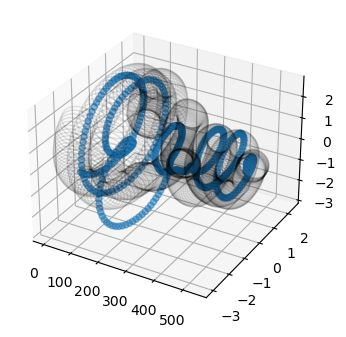

In [179]:
# diagonalize covariance matrix
x = μ_tT_best[0,:]
y = μ_tT_best[1,:]
t = np.arange(len(x))

cov = np.array([1,0.75,0.75,1]).reshape(2,2)

fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(1,1,1, projection='3d')

ax.scatter(xs=t,ys=x,zs=y,alpha=.5)

#cov = Σ_tT_best[0]
pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
# Using a special case to obtain the eigenvalues of this
# two-dimensional dataset.
ell_radius_x = np.sqrt(1 + pearson)
ell_radius_y = np.sqrt(1 - pearson)
for i in range(len(x)):
    ell = Ellipse((x[i], y[i]), width=ell_radius_x * 2, height=ell_radius_y * 2,facecolor='none',edgecolor='k',angle=45,alpha=.1)
    ax.add_patch(ell)
    pathpatch_2d_to_3d(ell,0,normal='x')
    pathpatch_translate(ell, (t[i], 0, 0))

#ellipse = Ellipse((x[0], y[0]), width=ell_radius_x * 2, height=ell_radius_y * 2,facecolor='none',edgecolor='k',angle=45)
#ax.add_patch(ellipse)
#pathpatch_2d_to_3d(ellipse,0,normal='x')


# Calculating the standard deviation of x from
# the squareroot of the variance and multiplying
# with the given number of standard deviations.
#scale_x = np.sqrt(cov[0, 0]) * 1
#mean_x = np.mean(x)

# calculating the standard deviation of y ...
#scale_y = np.sqrt(cov[1, 1]) * 1
#mean_y = np.mean(y)

#transf = transforms.Affine2D().rotate_deg(45)
#    .scale(scale_x, scale_y)
    #.translate(mean_x, mean_y)


#ellipse.set_transform(transf + ax.transData)




### fixed k fixed Q

forward


/tmp/ipykernel_42675/2008519625.py:31: RuntimeWarning: invalid value encountered in divide
  measurements /= measurements.std(0) # scaling


reverse


/tmp/ipykernel_42675/2008519625.py:31: RuntimeWarning: invalid value encountered in divide
  measurements /= measurements.std(0) # scaling


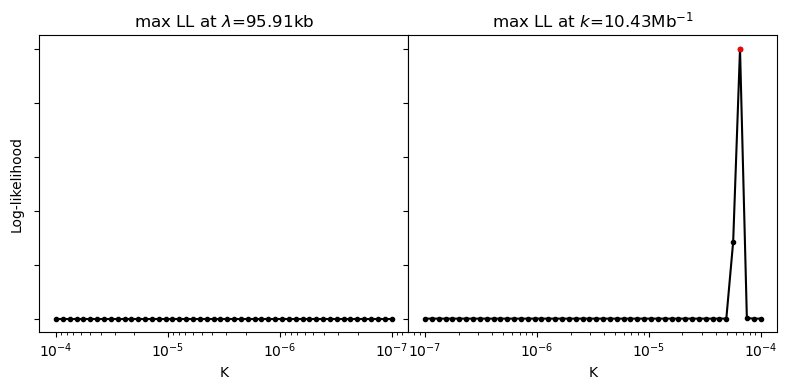

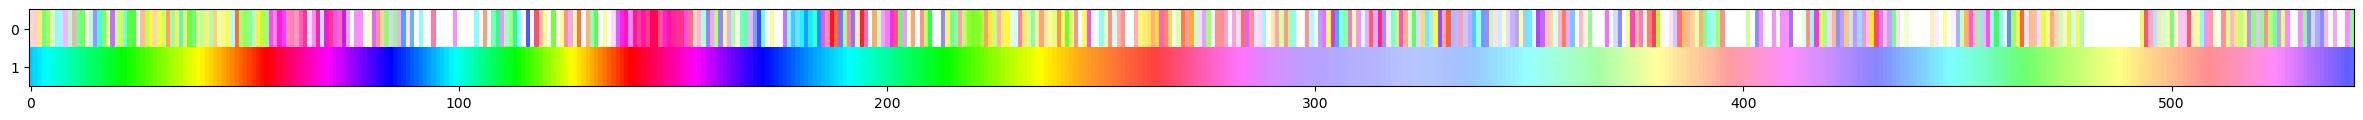

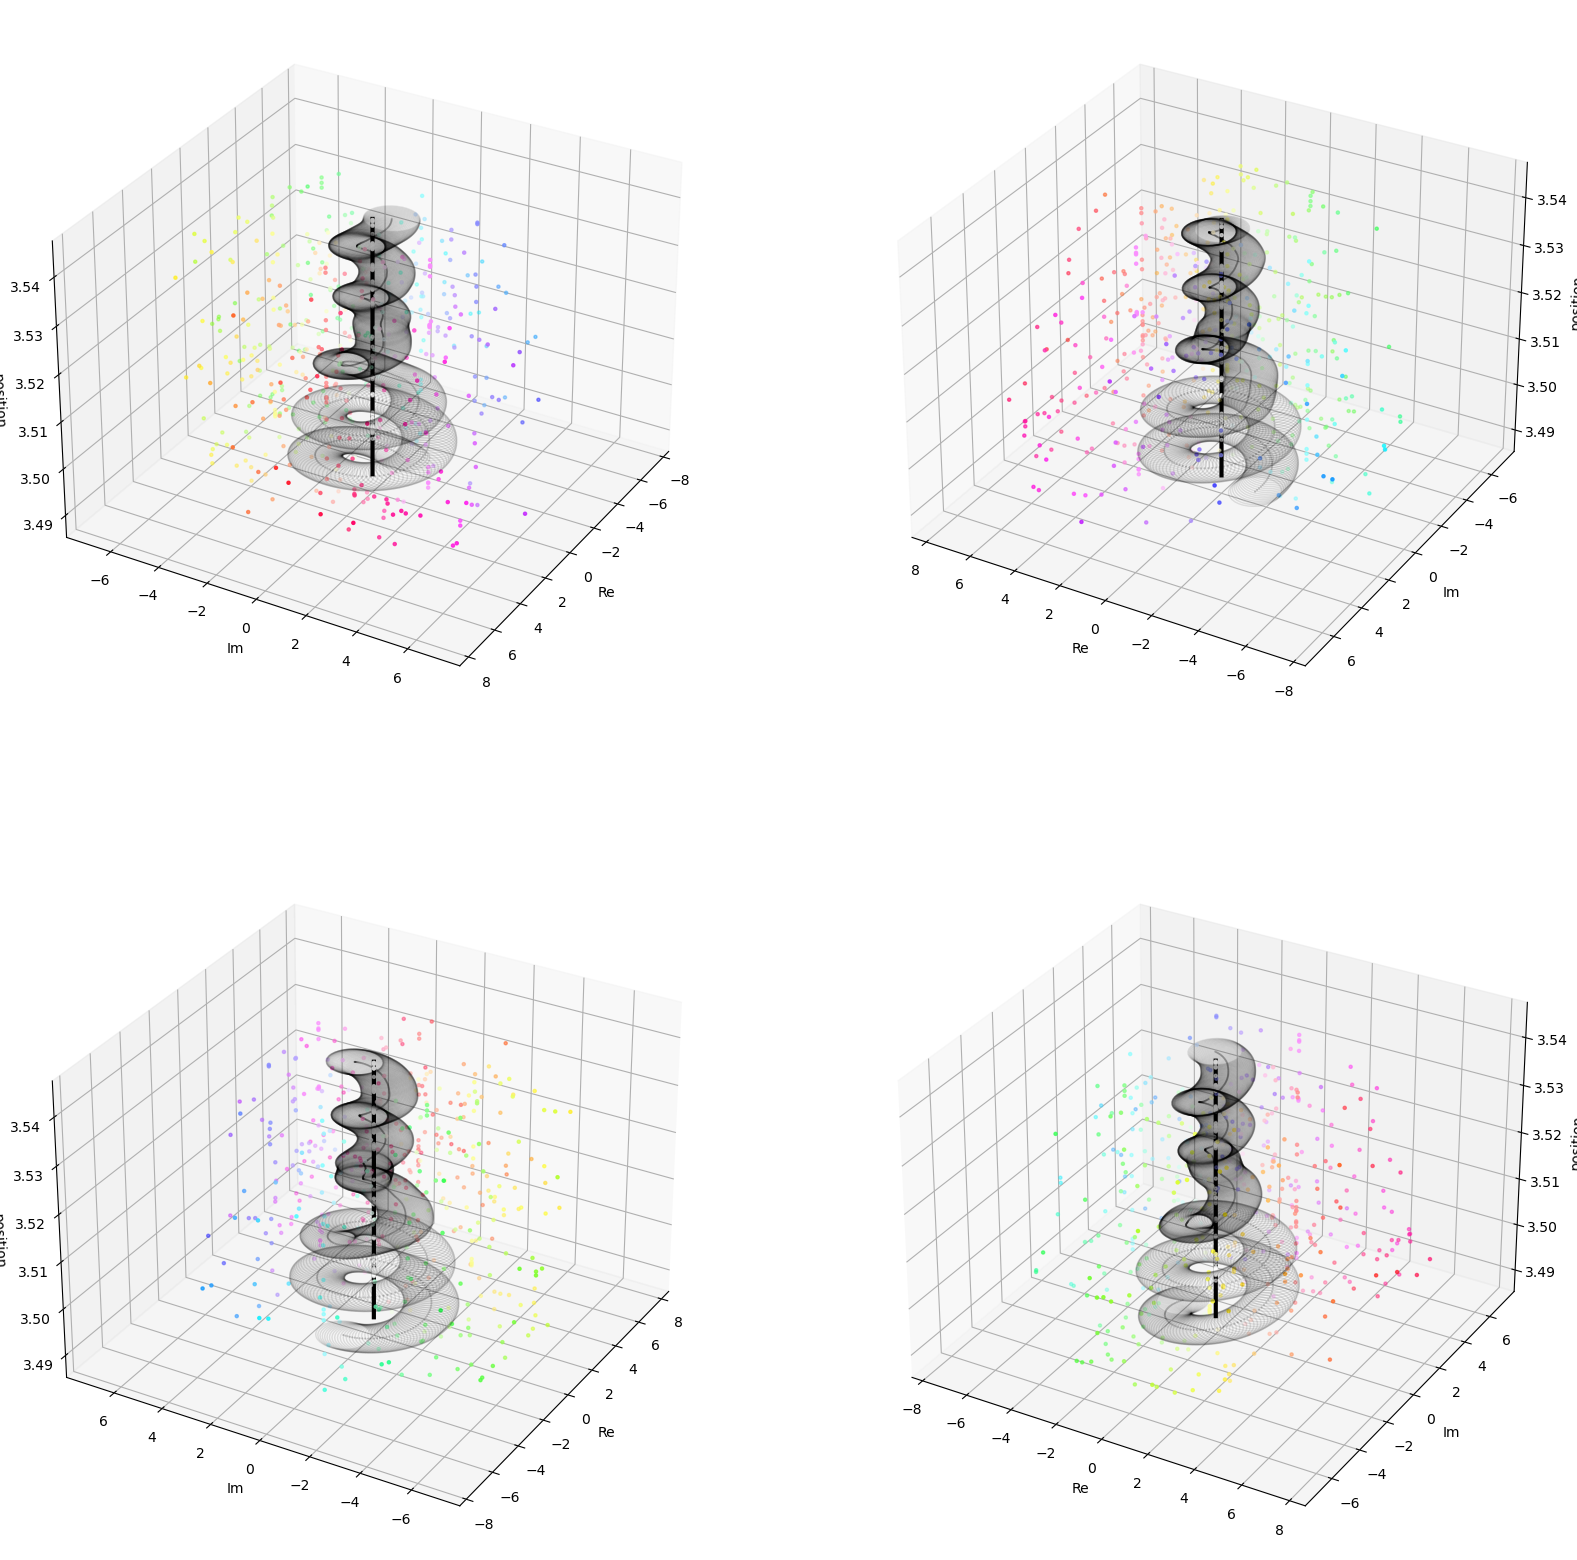

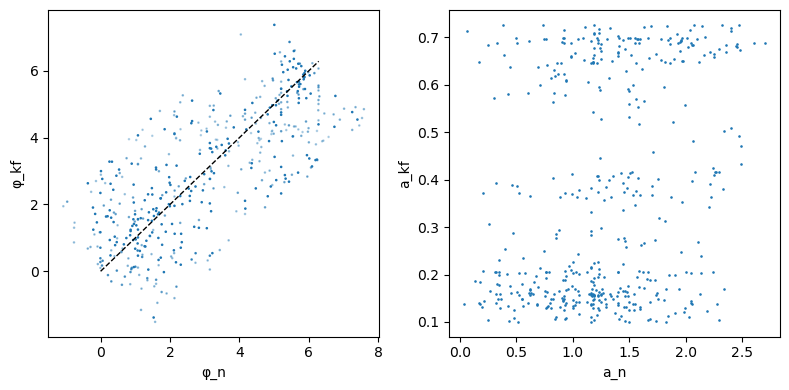

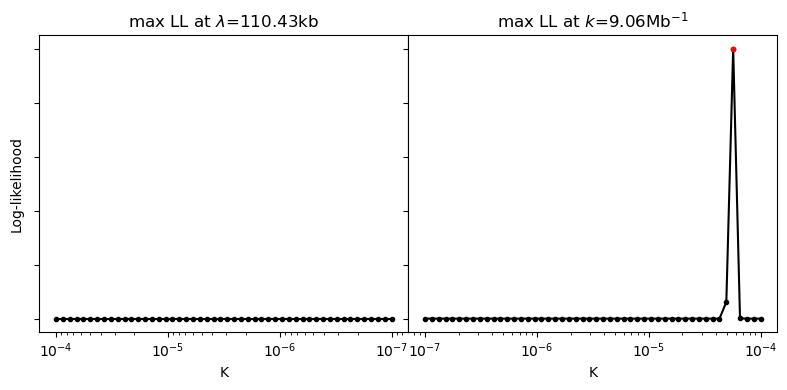

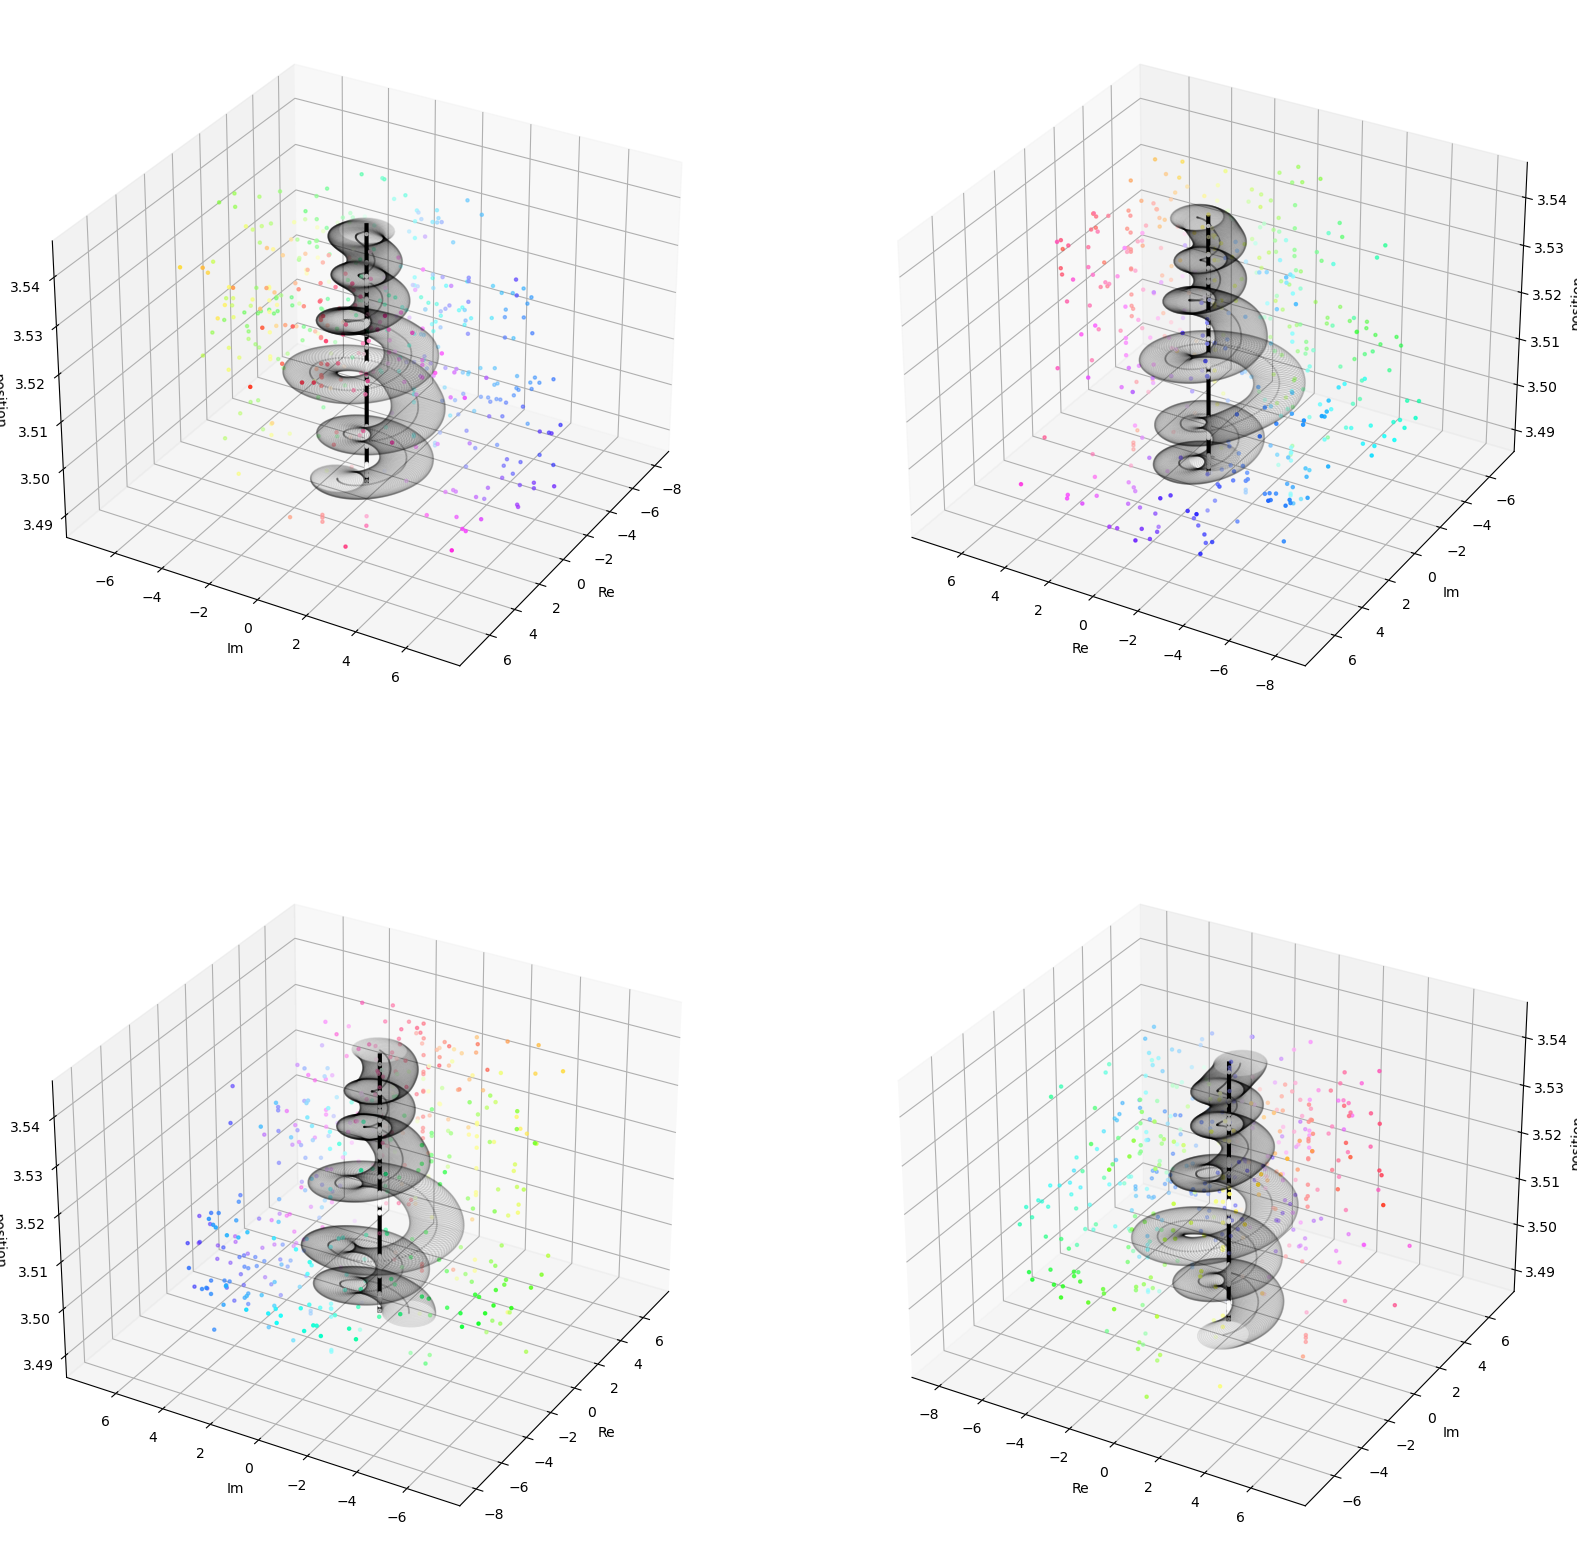

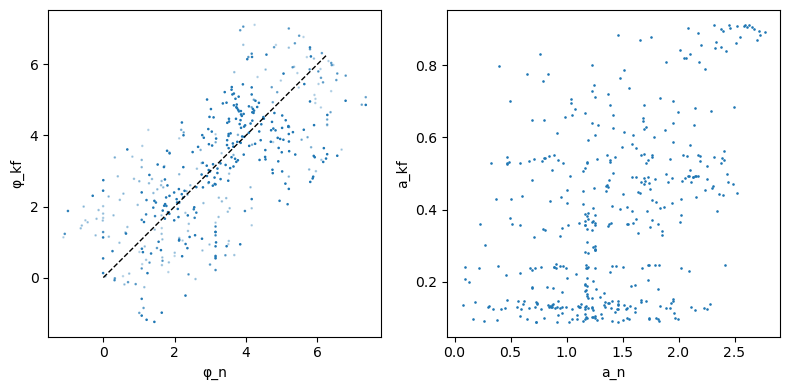

In [20]:


#My_win = [35_000_000, 35_150_000]
My_win = [34_891_000, 35_434_000]
#My_win = [34_000_000, 36_000_000]
#My_win = [26_500_000, 27_500_000]
#My_win = [26_650_000, 27_150_000]
#My_win = [24_000_000, 30_000_000]

# Kalman filter
#Λ = np.logspace(4.5, 6, 40) # wavelengths in bp
# add the negative values
#Λ = np.append(np.append(Λ,np.inf),-np.flip(Λ))
#K = 2*np.pi/Λ # wave numbers

K_max = -4
K_min = -7
K = np.logspace(K_max,K_min,50)
K = np.append(np.append(K,0),-np.flip(K))

ω = 2*np.pi/P # angular frequency
m = len(T) # number of time points
n = 2 # number complex state
dx = bin_size # distance between positions

for strand in Strands:
    print(strand)
    # get small region of the chromosome
    idx_pos = (df.index >= My_win[0]) & (df.index <= My_win[1])
    measurements = df.loc[idx_pos,[f"{t}{strand_dict[strand]}" for t in T]].values.T # time x position
    
    measurements -= measurements.mean(0) # centering
    measurements /= measurements.std(0) # scaling
    positions = df.loc[idx_pos,:].index # positions

    # fill missing values
    x = np.arange(positions[0],positions[-1]+1,bin_size)
    idx = [np.where(x==pos)[0][0] for pos in positions]
    X = np.zeros((measurements.shape[0],x.shape[0]))*np.nan
    X[:,idx] = measurements
    [m,N_mes] = X.shape # number of measurements

    del measurements, positions, idx_pos

    LL = np.zeros(len(K))

    μ_tT_best = np.zeros((n,N_mes))
    Σ_tT_best = np.zeros((n,n,N_mes))
    ll_best = -np.inf

    for l,k in enumerate(K):
        print(f'{l+1}/{len(K)}',end='\r')

        # forward model: rotation matrix
        θ = dx*k
        F = np.zeros((n,n))
        F[0,0] = np.cos(θ)
        F[0,1] = -np.sin(θ)
        F[1,0] = np.sin(θ)
        F[1,1] = np.cos(θ)
        # shrikage
        shrinkage = 0.1
        #F = (1-shrinkage)*F

        #F = np.array([[np.cos(θ), -np.sin(θ)], [np.sin(θ), np.cos(θ)]])
        # process noise
        Q = np.eye(n)*(θ**2)
        # observation model: inverse fourier transform
        H = np.zeros((m,2))
        H[:,0] = np.cos(ω*T)
        H[:,1] = -np.sin(ω*T)
        H /= 6
        # measurement noise: R = R_a * exp(-R_b * x) + R_c

        # initial state
        μ_0 = np.zeros(n)
        Σ_0 = np.eye(n)*1

        kf = KalmanFilter(F=F, H=H, Q=Q, R_a=R_a, R_b=R_b, R_c=R_c, μ_0=μ_0, Σ_0=Σ_0)

        μ_pred = np.zeros((n,N_mes))
        Σ_pred = np.zeros((n,n,N_mes))
        predicted = np.zeros((m,N_mes))
        μ_t = np.zeros((n,N_mes))
        Σ_t = np.zeros((n,n,N_mes))
        filtered = np.zeros((m,N_mes))
        for i,z in enumerate(X.T):
            μ_pred[:,i], Σ_pred[:,:,i] = kf.predict(i)
            μ_t[:,i], Σ_t[:,:,i] = kf.update(z)

        #test Forward-Backward
        forward_table, LL[l] = kf.fullForward(X)

        μ_tT, Σ_tT = kf.Backward(forward_table,F)
        μ_tT = np.array(μ_tT).T

        # save the best
        if LL[l] > ll_best:
            ll_best = LL[l]
            μ_tT_best = μ_tT
            Σ_tT_best = Σ_tT
    
        if False:
            predicted = H @ μ_pred
            filtered = H @ μ_t
            smoothed = H @ np.array(μ_tT).T

            # get residuals
            residuals = {}
            residuals['predicted'] = (measurements - predicted)**2
            residuals['filtered'] = (measurements - filtered)**2
            residuals['smoothed'] = (measurements - smoothed)**2

            for k,key in enumerate(residuals.keys()):
                Res[l,k] = residuals[key].mean()

    
    plot_log_likelihood(LL,K)
    
    # Compare best with bin by bin fourrier transform
    # Amp and phase of fourier transform
    f_n = np.sum(X * np.exp(-1j*ω*T[:,None]),0)
    f_n -= μ_genome
    a_n = 4/m * np.abs(f_n)
    # normalize
    φ_n = -np.arctan2(np.imag(f_n),np.real(f_n))
    φ_n[φ_n<0] += 2*np.pi # make sure φ_n is between 0 and 2pi

    # Amp and phase of kalman filter
    μ_tT_best_C = μ_tT_best[0,:] + 1j*μ_tT_best[1,:]
    μ_tT_best_C -= μ_genome
    a_kf = 4/m * np.abs(μ_tT_best_C)
    φ_kf = -np.arctan2(np.imag(μ_tT_best_C),np.real(μ_tT_best_C))
    φ_kf[φ_kf<0] += 2*np.pi # make sure φ_n is between 0 and 2pi

    plot_phase_per_bin(x,f_n,μ_tT_best_C,φ_n,φ_kf,a_n,a_kf,Σ_tT_best,tube=True)
    plot_scatter_phi_a(φ_n,φ_kf,a_n,a_kf)
    


In [11]:
a_kf

array([1.12266355, 1.12243811, 1.12220739, 1.1219801 , 1.12175091,
       1.12151655, 1.12127706, 1.12103249, 1.12078286, 1.1205438 ,
       1.1203091 , 1.12007466, 1.11983534, 1.11959118, 1.11934222,
       1.11908852, 1.11883011, 1.11856705, 1.11829938, 1.11802715,
       1.11775041, 1.11747641, 1.11720403, 1.11692299, 1.11663291,
       1.1163366 , 1.11603345, 1.11572885, 1.11541994, 1.11509842,
       1.11477668, 1.11445077, 1.11411535, 1.11377371, 1.11343022,
       1.11308293, 1.11273238, 1.11237785, 1.1120142 , 1.11163932,
       1.11125676, 1.11087232, 1.11048355, 1.1100874 , 1.1096823 ,
       1.10926812, 1.10885411, 1.10843347, 1.10800962, 1.10758207,
       1.10714441, 1.10669917, 1.10624642, 1.10578578, 1.10531826,
       1.10484165, 1.10436099, 1.1038724 , 1.10337755, 1.10287528,
       1.10236619, 1.1018536 , 1.10133274, 1.10080201, 1.1002666 ,
       1.09972637, 1.09918723, 1.09864228, 1.09808939, 1.09752986,
       1.09696702, 1.09640198, 1.09582765, 1.09524411, 1.09465

### fixed k rotating Q

forward


/tmp/ipykernel_42675/798917030.py:30: RuntimeWarning: invalid value encountered in divide
  measurements /= measurements.std(0) # scaling


reverse


/tmp/ipykernel_42675/798917030.py:30: RuntimeWarning: invalid value encountered in divide
  measurements /= measurements.std(0) # scaling


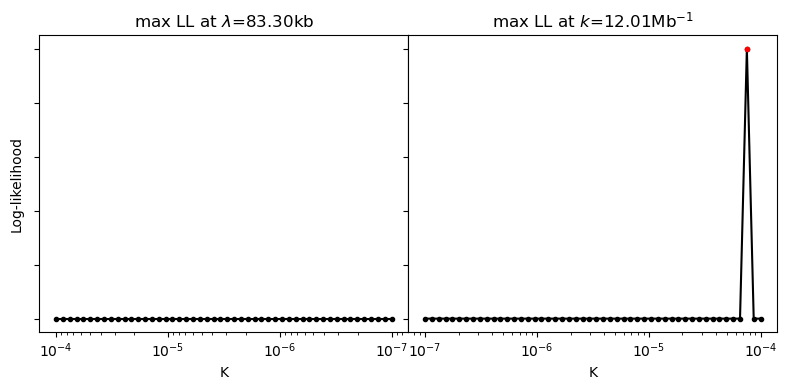

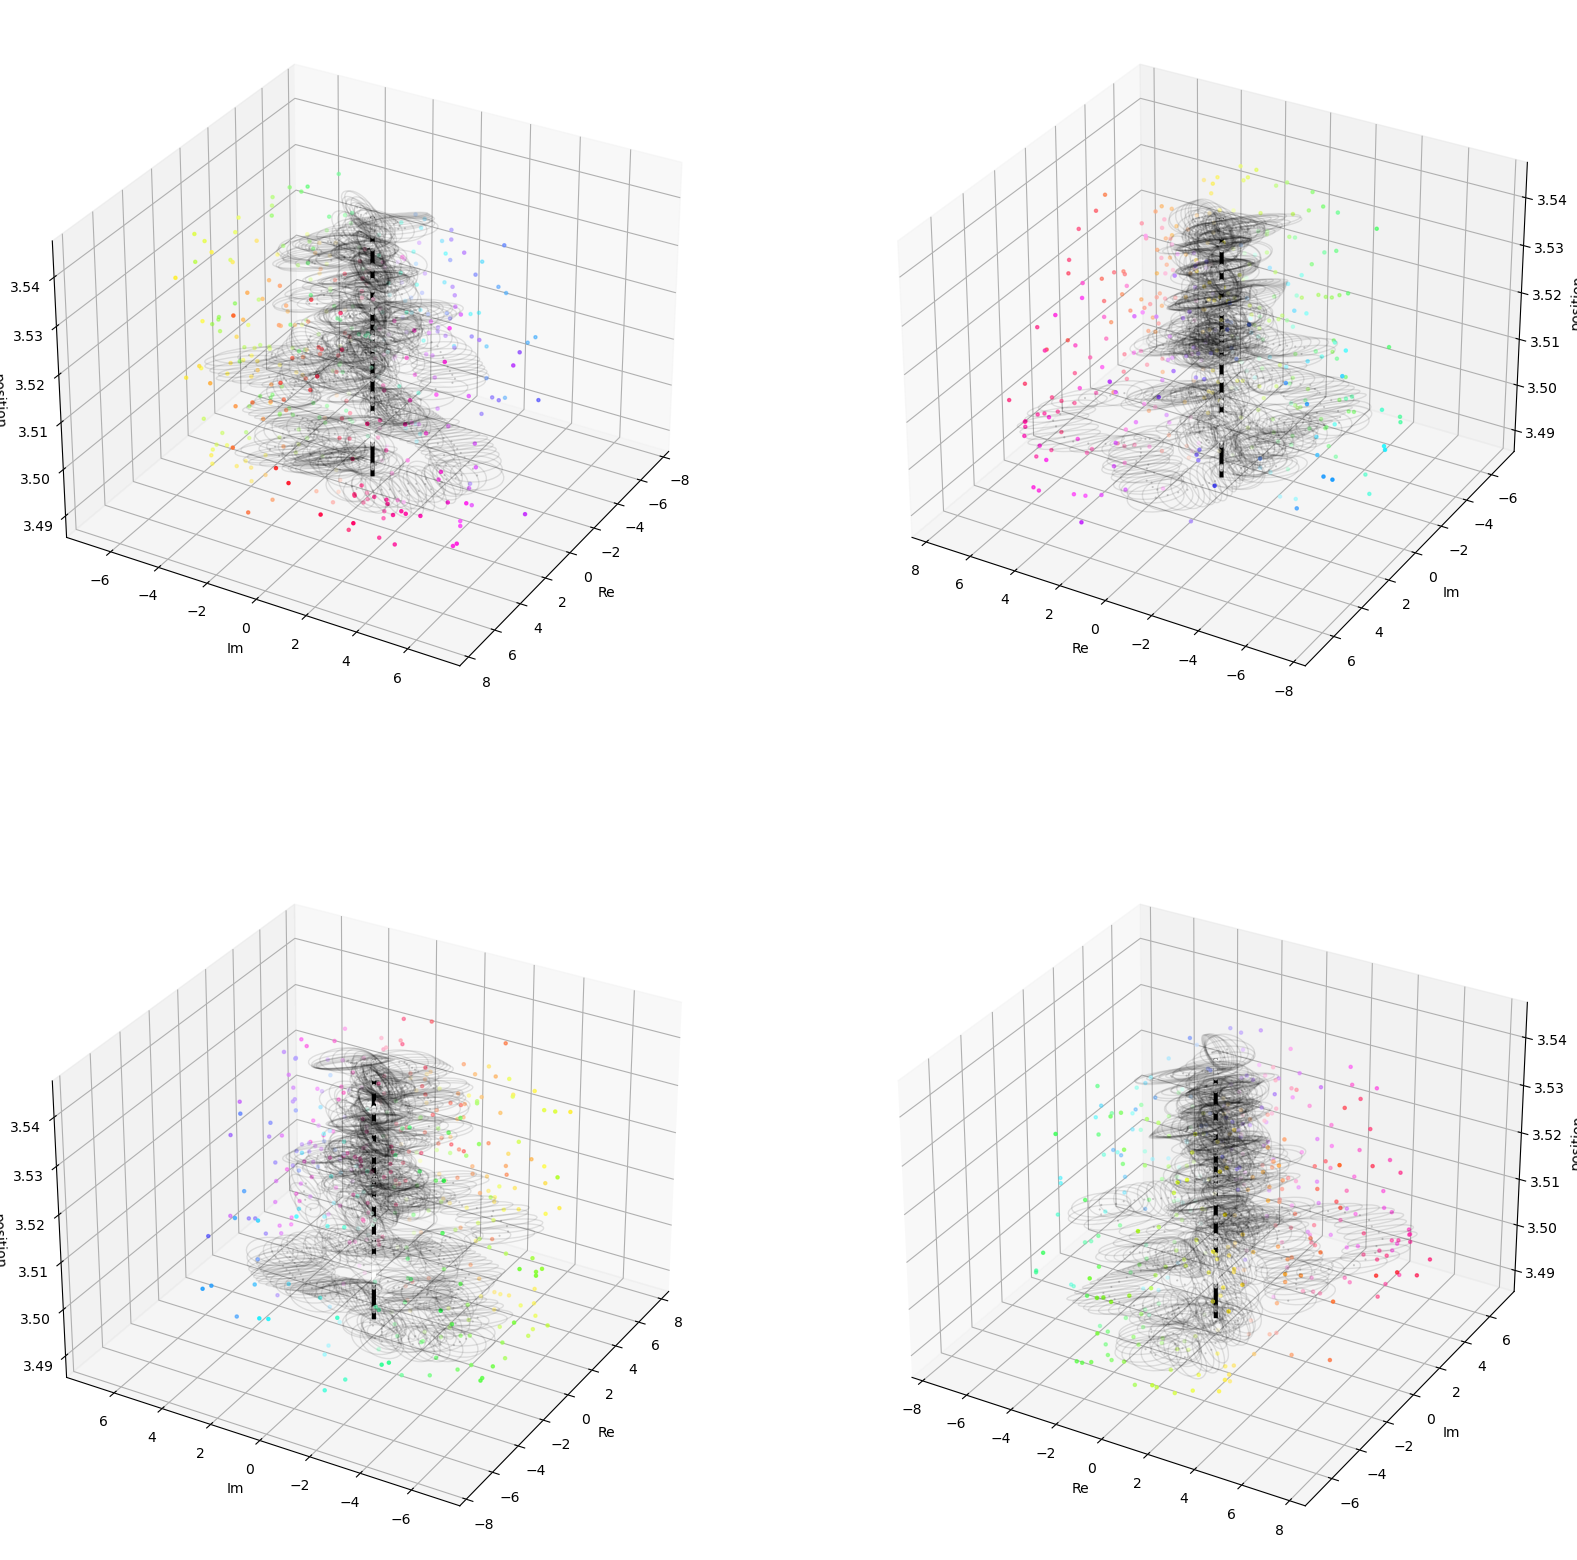

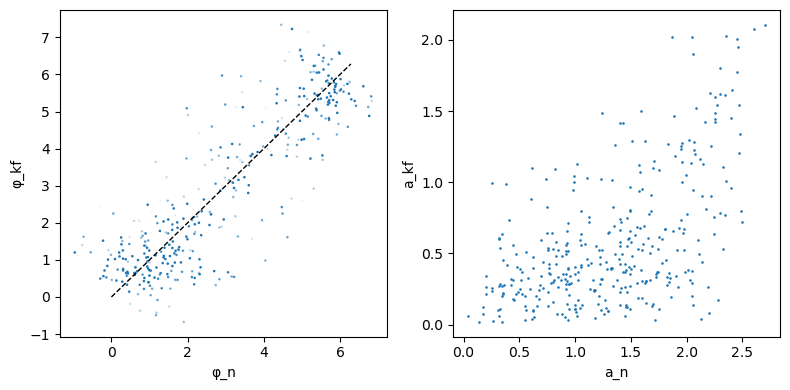

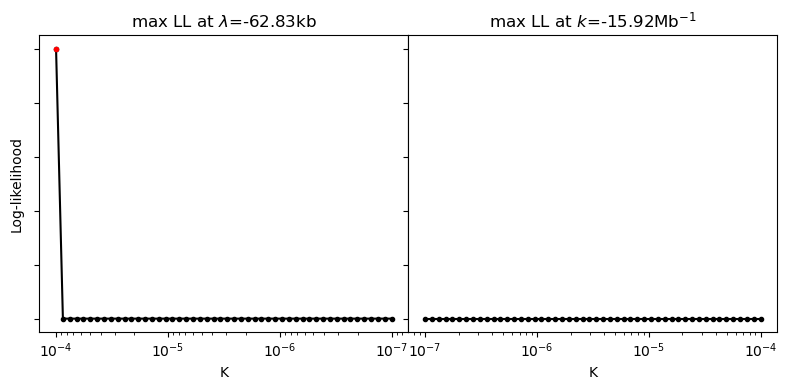

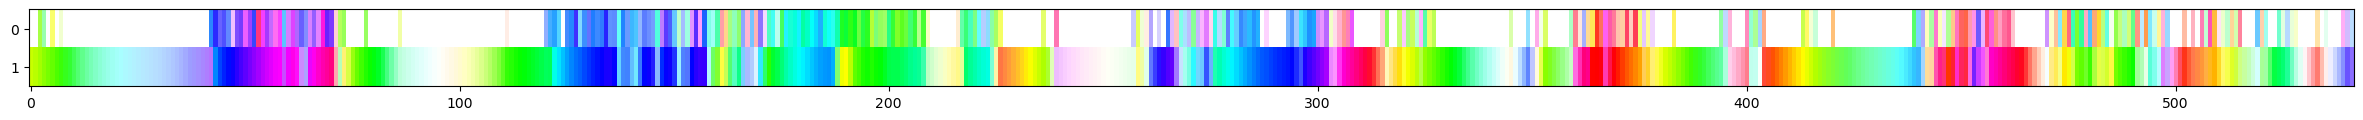

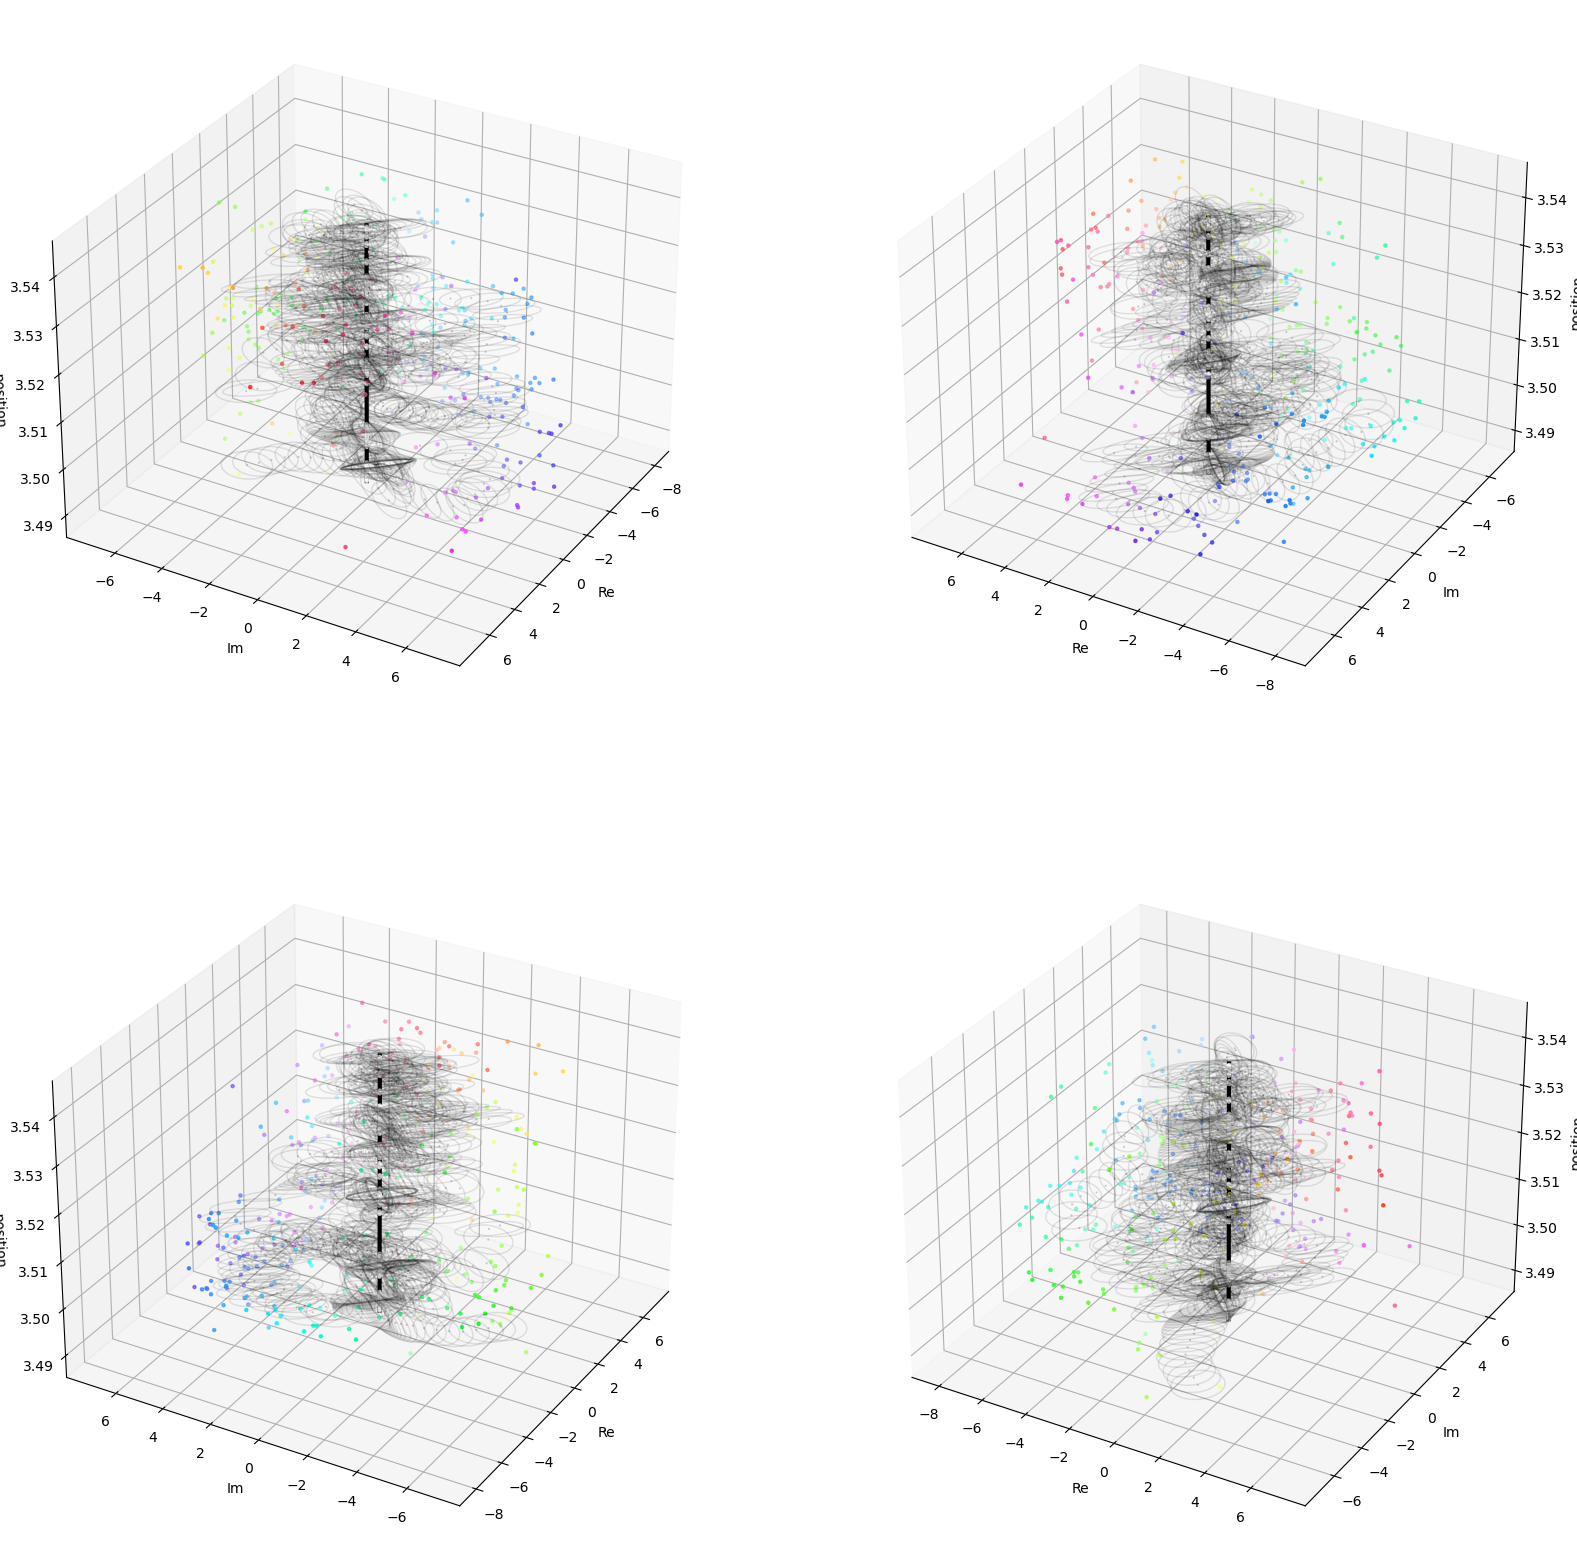

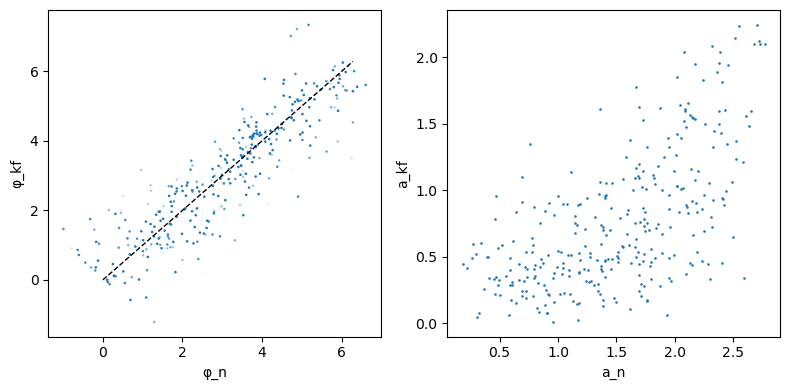

In [16]:
#My_win = [35_000_000, 35_150_000]
My_win = [34_891_000, 35_434_000]
#My_win = [34_000_000, 36_000_000]
#My_win = [26_500_000, 27_500_000]
#My_win = [26_750_000, 27_050_000]
#My_win = [24_000_000, 30_000_000]

# Kalman filter
#Λ = np.logspace(4.5, 6, 40) # wavelengths in bp
# add the negative values
#Λ = np.append(np.append(Λ,np.inf),-np.flip(Λ))
#K = 2*np.pi/Λ # wave numbers

K_max = -4
K_min = -7
K = np.logspace(K_max,K_min,50)
K = np.append(np.append(K,0),-np.flip(K))

ω = 2*np.pi/P # angular frequency
m = len(T) # number of time points
n = 2 # number complex state
dx = bin_size # distance between positions

for strand in Strands:
    print(strand)
    # get small region of the chromosome
    idx_pos = (df.index >= My_win[0]) & (df.index <= My_win[1])
    measurements = df.loc[idx_pos,[f"{t}{strand_dict[strand]}" for t in T]].values.T # time x position
    measurements -= measurements.mean(0) # centering
    measurements /= measurements.std(0) # scaling
    positions = df.loc[idx_pos,:].index # positions

    # fill missing values
    x = np.arange(positions[0],positions[-1]+1,bin_size)
    idx = [np.where(x==pos)[0][0] for pos in positions]
    X = np.zeros((measurements.shape[0],x.shape[0]))*np.nan
    X[:,idx] = measurements
    [m,N_mes] = X.shape # number of measurements

    del measurements, positions, idx_pos

    LL = np.zeros(len(K))

    μ_tT_best = np.zeros((n,N_mes))
    Σ_tT_best = np.zeros((n,n,N_mes))
    ll_best = -np.inf

    for l,k in enumerate(K):
        print(f'{(l+1)}/{len(K)}',end='\r')

        # forward model: rotation matrix
        θ = dx*k
        F = np.zeros((n,n))
        F[0,0] = np.cos(θ)
        F[0,1] = -np.sin(θ)
        F[1,0] = np.sin(θ)
        F[1,1] = np.cos(θ)
        # shrikage
        shrinkage = 0.1
        F = (1-shrinkage)*F

        # process noise
        Q = np.zeros((n,n))
        Q[0,0] = (4*θ)**2 # σ_r ^2
        Q[1,1] = (θ/2)**2 # σ_φ ^2
    
        # observation model: inverse fourier transform
        H = np.zeros((m,2))
        H[:,0] = np.cos(ω*T)
        H[:,1] = -np.sin(ω*T)
        H /= 6

        # initial state
        μ_0 = np.zeros(n)
        Σ_0 = np.eye(n)*1

        kf = KalmanFilter_rotating_Q(F=F, H=H, Q=Q, R_a=R_a, R_b=R_b, R_c=R_c, μ_0=μ_0, Σ_0=Σ_0)

        μ_pred = np.zeros((n,N_mes))
        Σ_pred = np.zeros((n,n,N_mes))
        predicted = np.zeros((m,N_mes))
        μ_t = np.zeros((n,N_mes))
        Σ_t = np.zeros((n,n,N_mes))
        filtered = np.zeros((m,N_mes))
        for i,z in enumerate(X.T):
            μ_pred[:,i], Σ_pred[:,:,i] = kf.predict(i)
            μ_t[:,i], Σ_t[:,:,i] = kf.update(z)

        #test Forward-Backward
        forward_table, LL[l] = kf.fullForward(X)

        μ_tT, Σ_tT = kf.Backward(forward_table,F)
        μ_tT = np.array(μ_tT).T

        # save the best
        if LL[l] > ll_best:
            ll_best = LL[l]
            μ_tT_best = μ_tT
            Σ_tT_best = Σ_tT

    plot_log_likelihood(LL,K)
    
    # Compare best with bin by bin fourrier transform
    # Amp and phase of fourier transform
    f_n = np.sum(X * np.exp(-1j*ω*T[:,None]),0)
    f_n -= μ_genome
    a_n = 4/m * np.abs(f_n)
    # normalize
    φ_n = -np.arctan2(np.imag(f_n),np.real(f_n))
    φ_n[φ_n<0] += 2*np.pi # make sure φ_n is between 0 and 2pi

    # Amp and phase of kalman filter
    μ_tT_best_C = μ_tT_best[0,:] + 1j*μ_tT_best[1,:]
    μ_tT_best_C -= μ_genome
    a_kf = 4/m * np.abs(μ_tT_best_C)
    φ_kf = -np.arctan2(np.imag(μ_tT_best_C),np.real(μ_tT_best_C))
    φ_kf[φ_kf<0] += 2*np.pi # make sure φ_n is between 0 and 2pi

    plot_phase_per_bin(x,f_n,μ_tT_best_C,φ_n,φ_kf,a_n,a_kf,Σ_tT_best,tube=True)
    plot_scatter_phi_a(φ_n,φ_kf,a_n,a_kf)



### k as hidden variable

forward


/tmp/ipykernel_16835/2723613452.py:16: RuntimeWarning: invalid value encountered in divide
  measurements /= measurements.std(0) # scaling


reverse


/tmp/ipykernel_16835/2723613452.py:16: RuntimeWarning: invalid value encountered in divide
  measurements /= measurements.std(0) # scaling


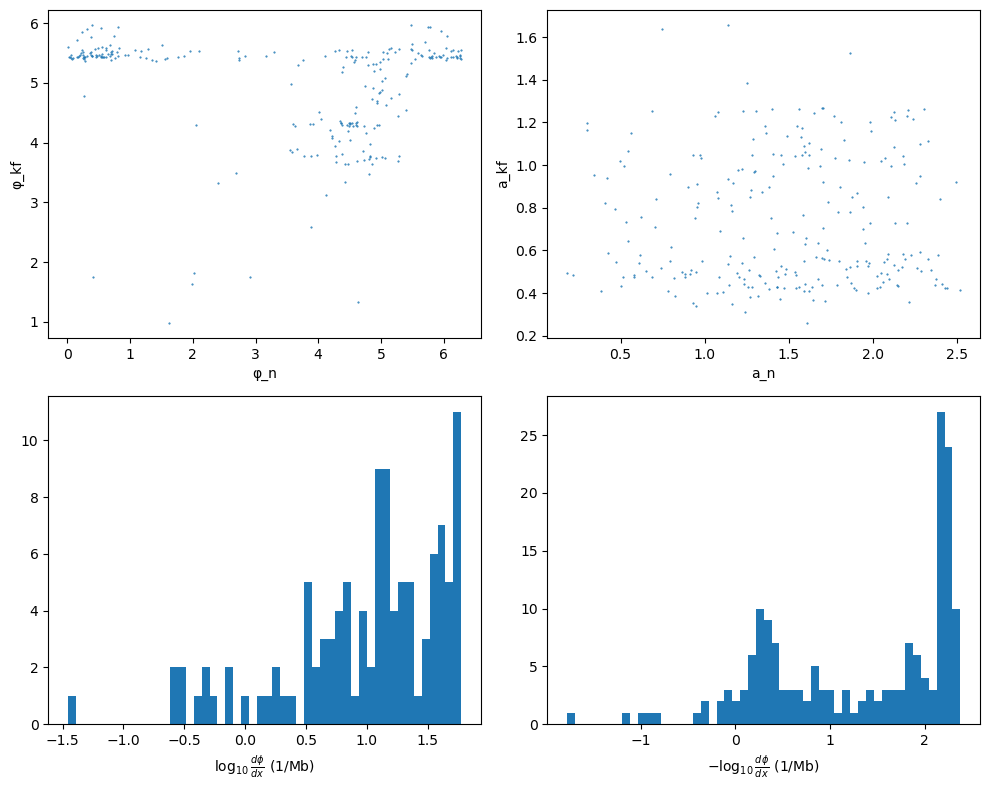

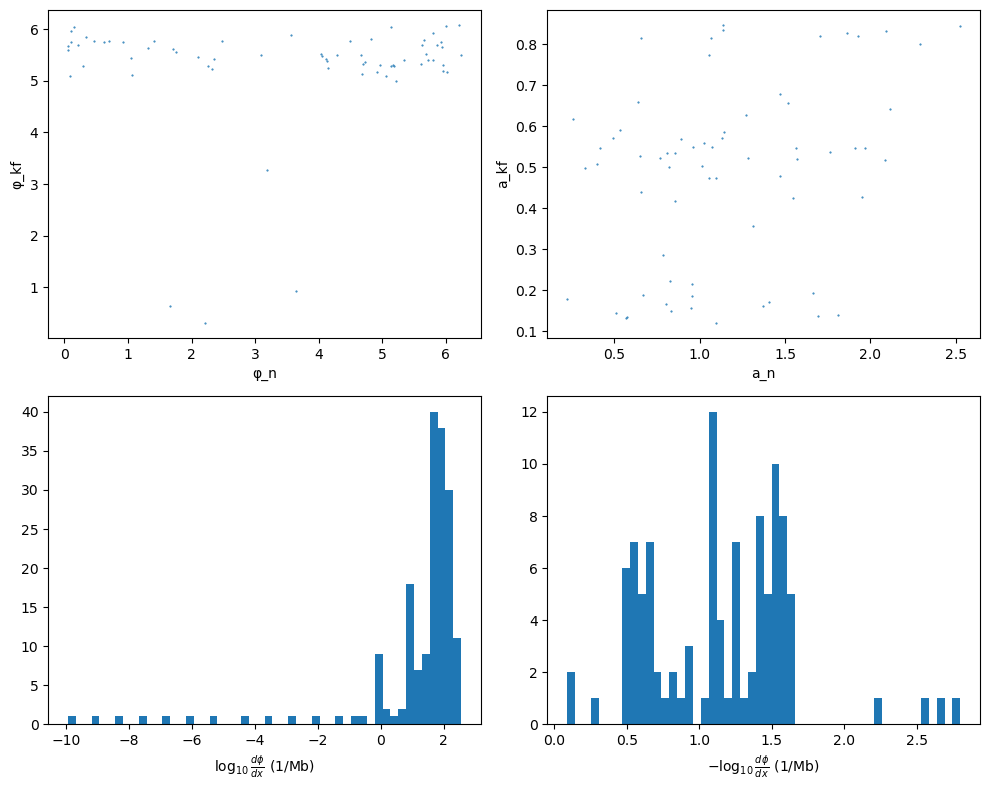

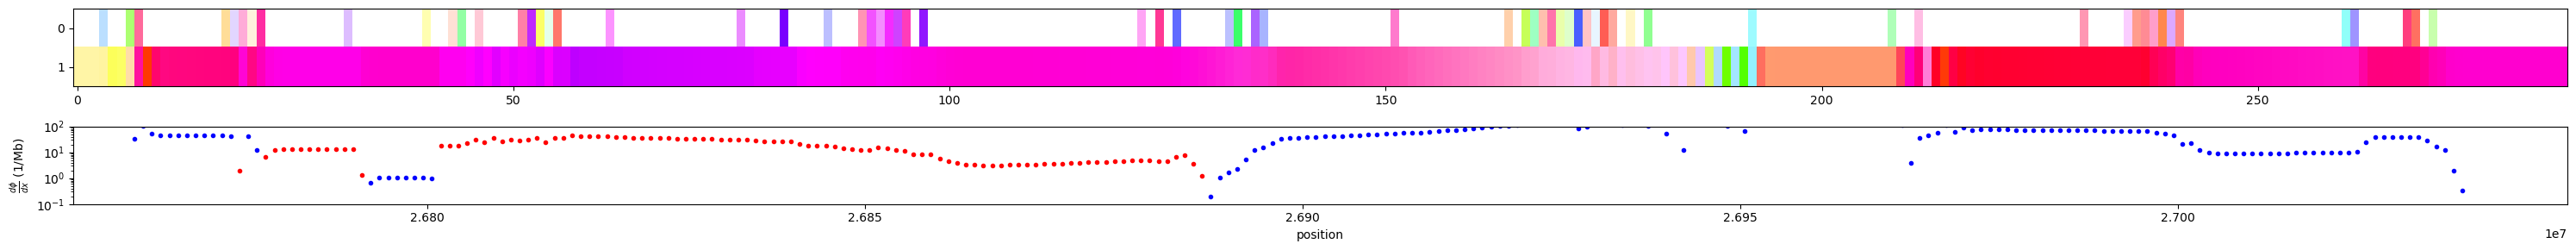

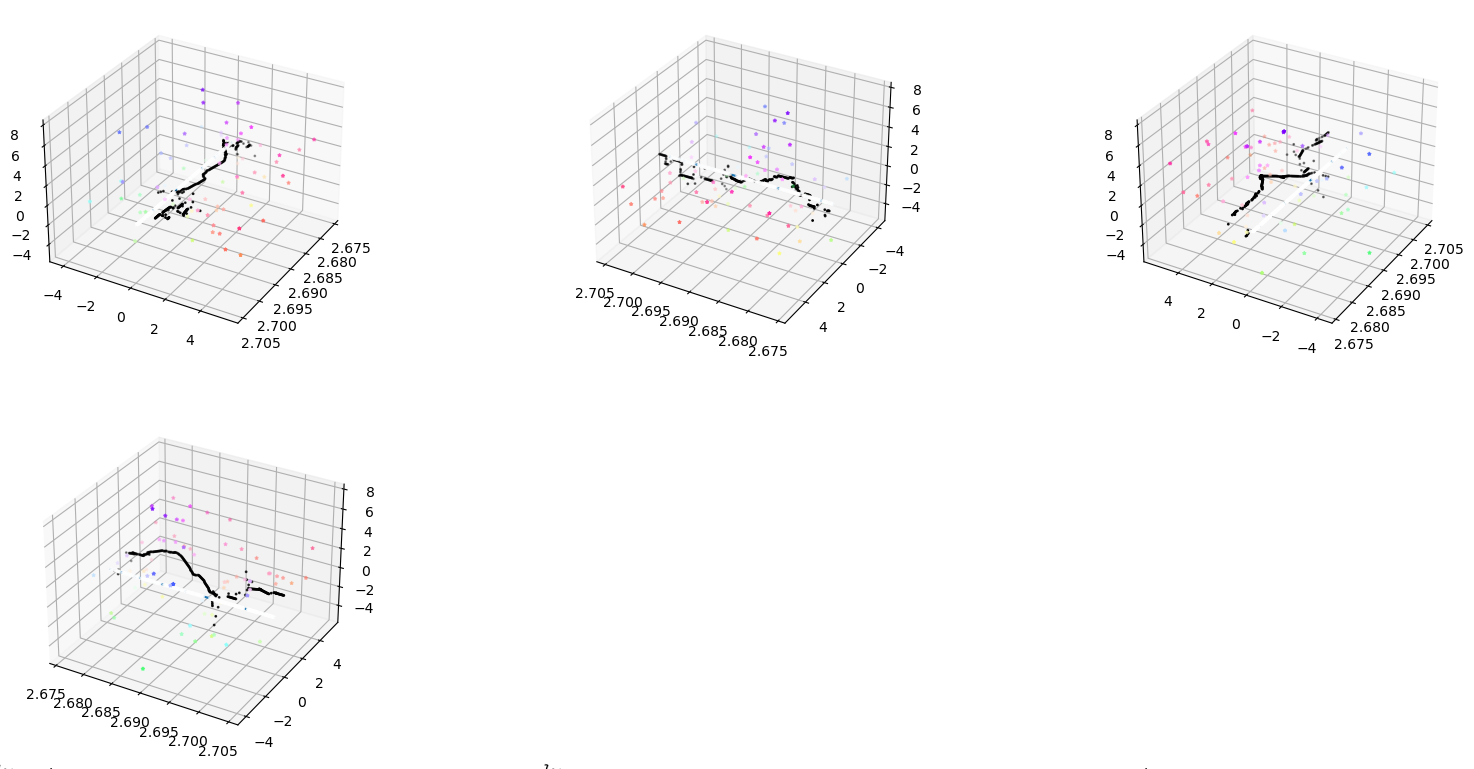

In [35]:
#My_win = [35_000_000, 35_150_000]
#My_win = [34_891_000, 35_434_000]
#My_win = [34_000_000, 36_000_000]
#My_win = [26_500_000, 27_500_000]
My_win = [26_750_000, 27_050_000]
#My_win = [24_000_000, 30_000_000]



for strand in Strands:
    print(strand)
    # get small region of the chromosome
    idx_pos = (df.index >= My_win[0]) & (df.index <= My_win[1])
    measurements = df.loc[idx_pos,[f"{t}{strand_dict[strand]}" for t in T]].values.T # time x position
    measurements -= measurements.mean(0) # centering
    measurements /= measurements.std(0) # scaling
    positions = df.loc[idx_pos,:].index # positions

    # fill missing values
    x = np.arange(positions[0],positions[-1]+1,bin_size)
    idx = [np.where(x==pos)[0][0] for pos in positions]
    X = np.zeros((measurements.shape[0],x.shape[0]))*np.nan
    X[:,idx] = measurements
    [m,N_mes] = X.shape # number of measurements

    del measurements, positions, idx_pos

    ω = 2*np.pi/P # angular frequency
    m = len(T) # number of time points
    n = 4 # number hidden state
    dx = bin_size # distance between positions

    # forward model: rotation matrix
    k = 0
    θ = dx*0
    F = np.zeros((n,n))
    F[0,0] = np.cos(θ)
    F[0,1] = -np.sin(θ)
    F[1,0] = np.sin(θ)
    F[1,1] = np.cos(θ)
    F[2,2] = 1
    F[3,3] = 1

    #F = np.array([[np.cos(θ), -np.sin(θ)], [np.sin(θ), np.cos(θ)]])
    # process noise
    Q = np.diag([1e-6,1e-6,1e-11,1e-11])
    Q[0,0] = .001 # σ_r ^2
    Q[1,1] = (θ/10)**2 # σ_φ ^2
    # observation model: inverse fourier transform
    H = np.zeros((m,n))
    H[:,0] = np.cos(ω*T)
    H[:,1] = -np.sin(ω*T)
    H /= 6

    # initial state
    μ_0 = np.ones(n)*.001
    Σ_0 = np.eye(n)*.1

    kf = KalmanFilter_k_hidden(F=F, H=H, Q=Q, R_a=R_a, R_b=R_b, R_c=R_c, μ_0=μ_0, Σ_0=Σ_0, dx=dx)

    μ_pred = np.zeros((n,N_mes))
    Σ_pred = np.zeros((n,n,N_mes))
    predicted = np.zeros((m,N_mes))
    μ_t = np.zeros((n,N_mes))
    Σ_t = np.zeros((n,n,N_mes))
    filtered = np.zeros((m,N_mes))
    for i,z in enumerate(X.T):
        μ_pred[:,i], Σ_pred[:,:,i] = kf.predict(i)
        μ_t[:,i], Σ_t[:,:,i] = kf.update(z)

    #Forward-Backward
    forward_table, ll = kf.fullForward(X)
    μ_tT, Σ_tT = kf.Backward(forward_table,F)
    μ_tT = np.array(μ_tT).T

    # Compare best with bin by bin fourrier transform

    # fourier transform
    f_n = np.sum(X * np.exp(-1j*ω*T[:,None]),0)
    a_n = 4/m * np.abs(f_n)
    # normalize
    φ_n = -np.arctan2(np.imag(f_n),np.real(f_n))
    φ_n[φ_n<0] += 2*np.pi # make sure φ_n is between 0 and 2pi
    # in between 0 and 2pi

    # plot phase per bin
    h = φ_n/(2*np.pi)
    s = a_n/np.nanmax(a_n)
    v = np.ones(len(x))
    color_f = hsv_to_rgb_v(h,s,v)
    f_n[np.isnan(f_n)] = 0

    μ_tT_C = μ_tT[0,:] + 1j*μ_tT[1,:]
    μ_tT_C -= μ_genome
    a_kf = 4/m * np.abs(μ_tT_C)
    φ_kf = -np.arctan2(np.imag(μ_tT_C),np.real(μ_tT_C))
    φ_kf[φ_kf<0] += 2*np.pi # make sure φ_n is between 0 and 2pi

    dφ_dt = ( μ_tT[3,:]*μ_tT[0,:] - μ_tT[2,:]*μ_tT[1,:] )/( μ_tT[0,:]**2 + μ_tT[1,:]**2 )
    # change unit rad/bp -> 1/kb
    dφ_dt /= 2*np.pi
    dφ_dt *= 1e6

    fig,axes = plt.subplots(2,2,figsize=(10,8))
    ax = axes[0,0]
    ax.scatter(φ_n,φ_kf,s=1,marker='.')
    ax.set_xlabel('φ_n')
    ax.set_ylabel('φ_kf')

    ax = axes[0,1]
    ax.scatter(a_n,a_kf,s=1,marker='.')
    ax.set_xlabel('a_n')
    ax.set_ylabel('a_kf')

    ax = axes[1,0]
    ax.hist(np.log10(dφ_dt[dφ_dt>0]),bins=50)
    ax.set_xlabel(r'$\log_{10} \frac{d\phi}{dx}$ (1/Mb)')

    ax = axes[1,1]
    ax.hist(np.log10(-dφ_dt[dφ_dt<0]),bins=50)
    ax.set_xlabel(r'$-\log_{10} \frac{d\phi}{dx}$ (1/Mb)')

    fig.tight_layout()

    # plot phase per bin
    h = φ_kf/(2*np.pi)
    s = a_kf/a_kf.mean()
    s[s>1] = 1
    v = np.ones(len(x))
    color_kf = hsv_to_rgb_v(h,s,v)
    Φ = np.ones((2,len(x),3))
    Φ[0,:] = color_f
    Φ[1,:] = color_kf


    fig, axes = plt.subplots(2,1,figsize=(30,3))

    ax = axes[0]
    ax.imshow(Φ,aspect='auto',interpolation='none')

    ax = axes[1]

    idx_pos = dφ_dt > 0
    ax.plot(x[idx_pos],dφ_dt[idx_pos],'b.')
    idx_neg = dφ_dt < 0
    ax.plot(x[idx_neg],-dφ_dt[idx_neg],'r.')
    ax.set_ylim(1e-1,1e2)
    ax.set_yscale('log')
    ax.set_xlim(x[0],x[-1])
    ax.set_xlabel('position')
    ax.set_ylabel(r'$\frac{d\phi}{dx}$ (1/Mb)')

    fig.tight_layout()

    fig = plt.figure(figsize=(20,20))
    for f,azim in enumerate( range(30,360,90) ):
        ax = fig.add_subplot(4,3,f+1, projection='3d')
        ax.scatter(xs=x, ys=f_n.real, zs=f_n.imag,color=Φ[0,:],s=5,marker='*')
        ax.scatter(xs=x, ys=μ_tT_C.real, zs=μ_tT_C.imag,color='k',s=1,marker='o')
        #ax.plot3D(positions,f_n.real,f_n.imag,color='k',linewidth=0.5)
        #for i in range(len(positions)):
        #    ax.plot3D([positions[i],positions[i]],[f_n.real[i],μ_tT_best_C.real[i]],[f_n.imag[i],μ_tT_best_C.imag[i]],color='k',linewidth=0.5)
        #ax.plot3D(positions,μ_tT_best_C.real,μ_tT_best_C.imag,color='k',linewidth=0.5)
        ax.plot3D(x,np.zeros(len(x)),np.zeros(len(x)))
        ax.view_init(elev=30, azim=azim, roll=0)

                

## Fourier transform

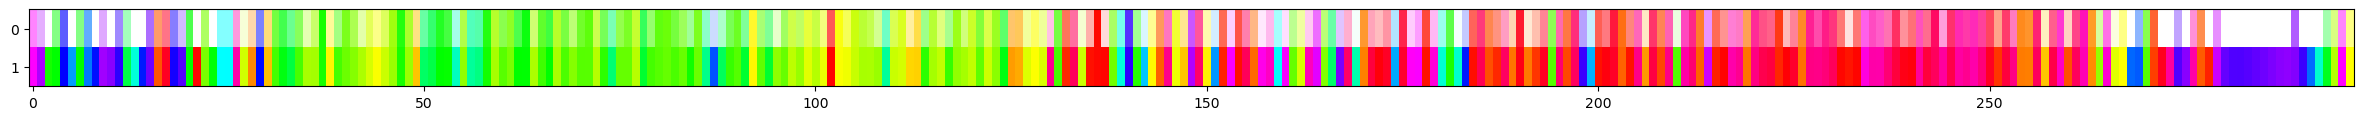

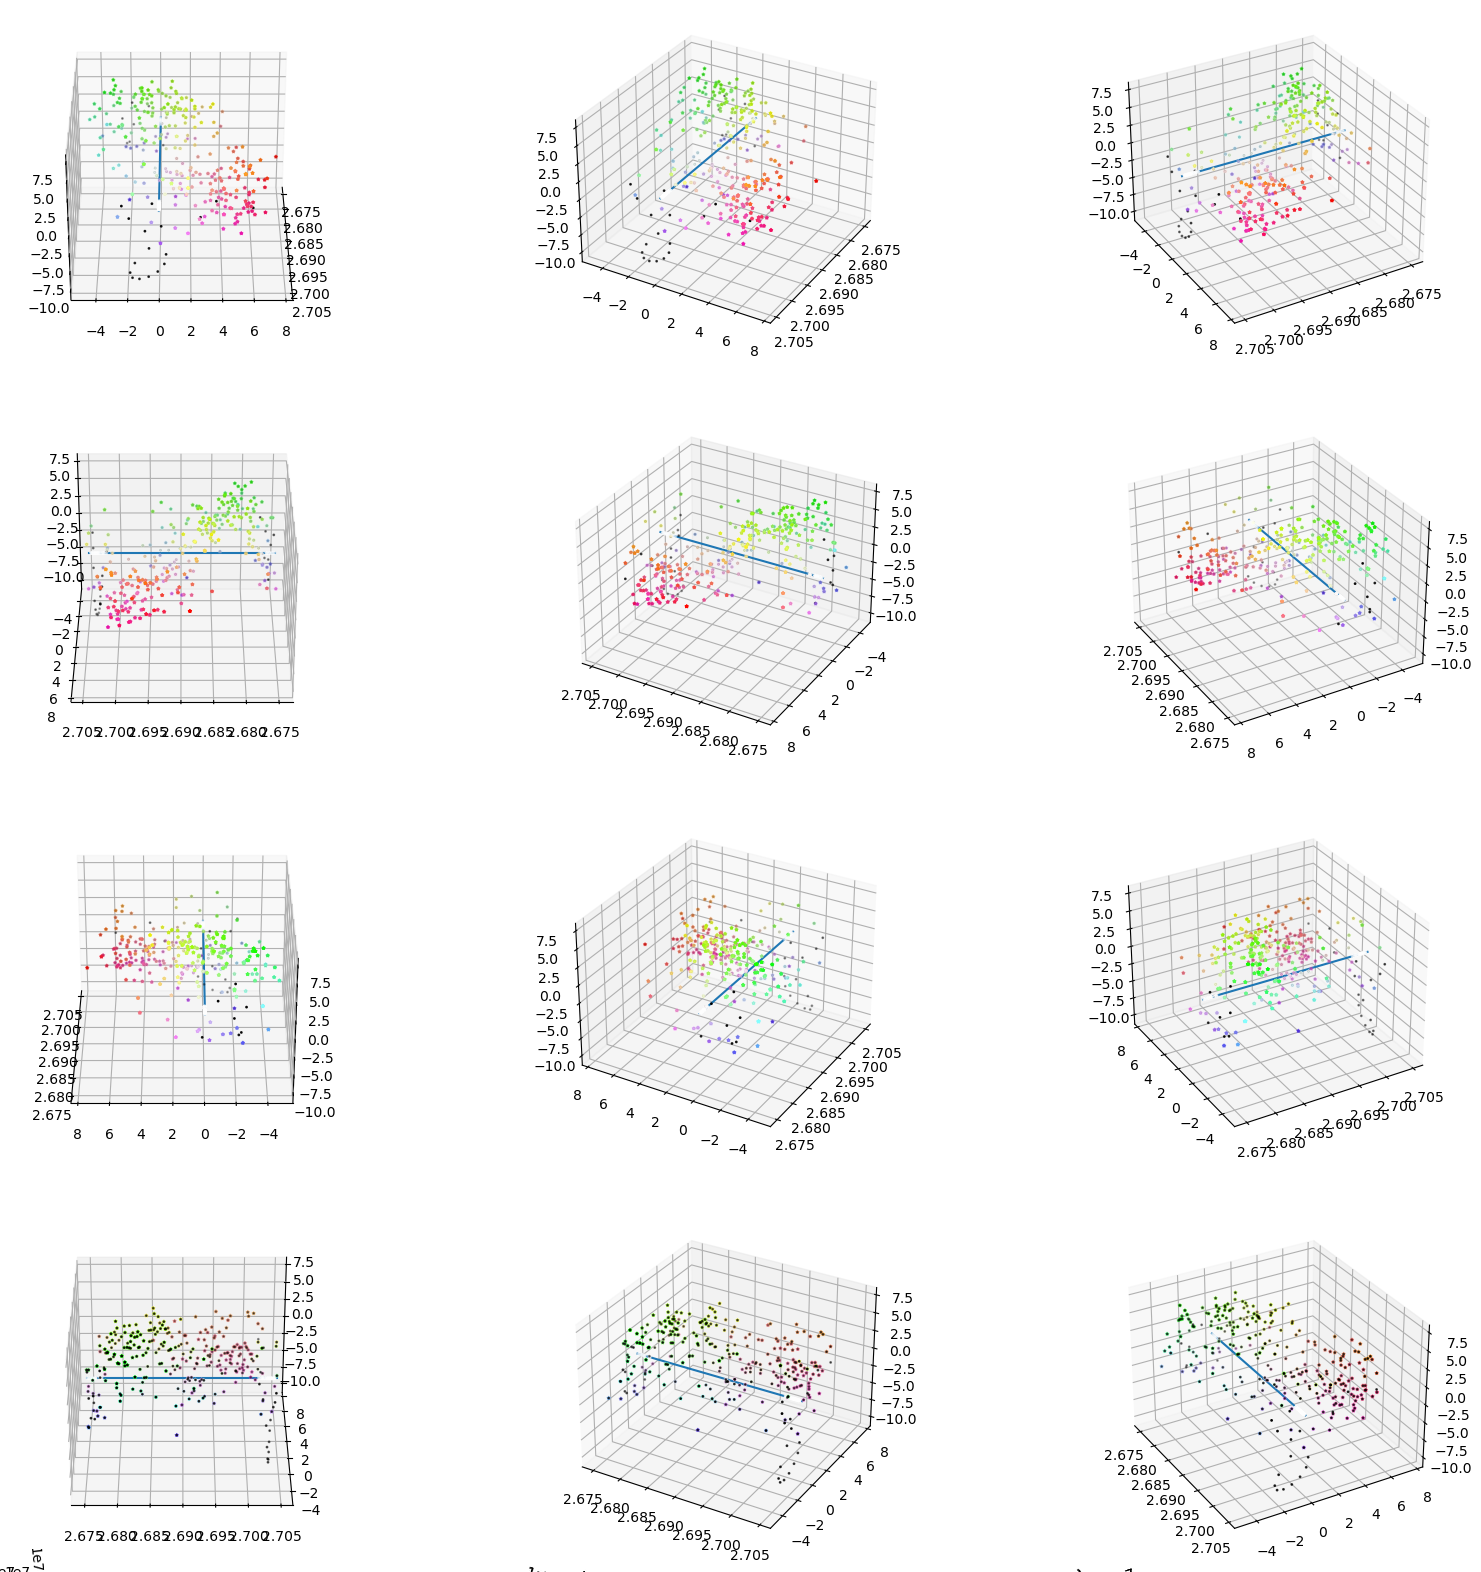

In [7]:
# Compare best with bin by bin fourrier transform

# fourier transform
f_n = np.sum(X * np.exp(-1j*ω*T[:,None]),0)
a_n = np.abs(f_n)
# normalize
φ_n = np.angle(f_n)
φ_n[φ_n<0] += 2*np.pi # make sure φ_n is between 0 and 2pi
# in between 0 and 2pi

# plot phase per bin
h = φ_n/(2*np.pi)
s = a_n/np.nanmax(a_n)
v = np.ones(len(x))
color_f = hsv_to_rgb_v(h,s,v)
f_n[np.isnan(f_n)] = 0

μ_tT_best_C = μ_tT_best[0,:] + 1j*μ_tT_best[1,:]
a_kf = np.abs(μ_tT_best_C)
φ_kf = np.angle(μ_tT_best_C)
φ_kf[φ_kf<0] += 2*np.pi # make sure φ_n is between 0 and 2pi

h = φ_kf/(2*np.pi)
s = np.ones(len(x))#a_kf/a_kf.max()
v = np.ones(len(x))
color_kf = hsv_to_rgb_v(h,s,v)

fig = plt.figure(figsize=(8,4))
plt.subplot(121)
plt.scatter(φ_n,φ_kf,s=1,marker='.')
plt.xlabel('φ_n')
plt.ylabel('φ_kf')

plt.subplot(122)
plt.scatter(a_n,a_kf,s=1,marker='.')
plt.xlabel('a_n')
plt.ylabel('a_kf')

fig.tight_layout()

# plot phase per bin
Φ = np.ones((2,len(x),3))
Φ[0,:] = color_f
Φ[1,:] = color_kf
fig = plt.figure(figsize=(30,1))
plt.imshow(Φ,aspect='auto',interpolation='none')

if True:
    fig = plt.figure(figsize=(20,20))
    for f,azim in enumerate( range(0,360,30) ):
        ax = fig.add_subplot(4,3,f+1, projection='3d')
        ax.scatter(xs=x, ys=f_n.real, zs=f_n.imag,color=Φ[0,:],s=5,marker='*')
        ax.scatter(xs=x, ys=μ_tT_best_C.real, zs=μ_tT_best_C.imag,color='k',s=1,marker='o')
        #ax.plot3D(positions,f_n.real,f_n.imag,color='k',linewidth=0.5)
        #for i in range(len(positions)):
        #    ax.plot3D([positions[i],positions[i]],[f_n.real[i],μ_tT_best_C.real[i]],[f_n.imag[i],μ_tT_best_C.imag[i]],color='k',linewidth=0.5)
        #ax.plot3D(positions,μ_tT_best_C.real,μ_tT_best_C.imag,color='k',linewidth=0.5)
        ax.plot3D(x,np.zeros(len(x)),np.zeros(len(x)))
        ax.view_init(elev=30, azim=azim, roll=0)


    #plt.draw()
    #plt.pause(.5)
#plt.show()

if False:
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')

    # Grab some example data and plot a basic wireframe.
    ax.plot_wireframe(x, y ,z , rstride=10, cstride=10)

    # Set the axis labels
    ax.set_xlabel('position')
    ax.set_ylabel('Re(f_n)')
    ax.set_zlabel('Im(f_n)')

    # Rotate the axes and update
    for angle in range(0, 360 + 1,20):
        # Normalize the angle to the range [-180, 180] for display
        angle_norm = (angle + 180) % 360 - 180

        # Cycle through a full rotation of elevation, then azimuth, roll, and all
        elev = azim = roll = 0
        if angle <= 360:
            elev = angle_norm
        elif angle <= 360*2:
            azim = angle_norm
        elif angle <= 360*3:
            roll = angle_norm
        else:
            elev = azim = roll = angle_norm

        # Update the axis view and title
        ax.view_init(elev, azim, roll)
        plt.title('Elevation: %d°, Azimuth: %d°, Roll: %d°' % (elev, azim, roll))

        plt.draw()
        plt.pause(.001)


In [38]:
np.sum(~np.isnan(f_n) ) 

273

In [33]:
color_f.shape

(297, 3)

In [60]:
v.shape

(1000,)

# Test Fourier transform 

In [121]:
# Oscillation paramters
P = 24
T = np.linspace(0,48,1000)
ω = 2*np.pi/P # angular frequency
A_true = 4.2
φ_true = 2/P*(2*np.pi)

# generate data
x_t = A_true * np.cos(ω*T-φ_true) + .1*A_true*np.random.normal(0,1,len(T))

# fourier transform
X_n = 1/len(T) * np.sum( x_t * np.exp(-1j*ω*T) )
A_f_f = 2*np.sqrt(X_n.real**2 + X_n.imag**2)
#φ_f_f = np.angle(X_n)
φ_f_f = np.arctan(-X_n.imag/X_n.real)

# inverse fourier transform
x_t_recon = 2 * np.real( X_n * np.exp(1j*ω*T) )
#A_f_t = np.sqrt(x_t_recon[0]**2 + x_t_recon[1]**2)
#φ_f_t = np.arctan2(x_t_recon[1],x_t_recon[0])


H = np.zeros((len(T),2))
H[:,0] = np.cos(ω*T)
H[:,1] = -np.sin(ω*T)
H *= 2
x_t_recon_H = H @ np.array([X_n.real,X_n.imag])
#A_H = np.sqrt(x_t_recon_H[0]**2 + x_t_recon_H[1]**2)
#φ_H = np.arctan2(x_t_recon_H[1],x_t_recon_H[0])

plt.figure()
plt.subplot(121)
plt.plot(T,x_t,label=rf'Fourier $A$={A_f_f:.2f}, $\phi$={φ_f_f/(2*np.pi)*P:.2f}')
plt.plot(T,x_t_recon,label=rf'$F^{-1}(X_n)$')# $A$={A_f_t:.2f}, $\phi$={φ_f_t/(2*np.pi)*P:.2f}')
plt.plot(T,x_t_recon_H,':',label=rf'$H\cdot X_n$')# $A$={A_H:.2f}, $\phi$={φ_H/(2*np.pi)*P:.2f}')
plt.title(r'True parameters: $A$ = %.2f, $\phi$ = %.2f' % (A_true,φ_true/(2*np.pi)*P))
plt.legend(loc='lower center')
plt.ylim(-10,10)
plt.xticks(np.arange(0,48+1,4))

# plot amplitude and phase in a polar plot
ax = plt.subplot(122, projection='polar')
ax.plot([0,φ_true],[0, A_true],'r-x',label='True')
ax.plot([0,φ_f_f],[0,A_f_f],'b:.',label=r'$X_n$')
ax.legend(loc='upper left')
ax.set_rmax(5)
#ax.set_rticks([0.5, 1, 1.5, 2])  # Less radial ticks
#ax.set_rlabel_position(-22.5)  # Move radial labels away from plotted line
#ax.grid(True)

plt.tight_layout()


if False:
    plt.figure()
    plt.scatter(x_t,x_t_recon)

    c = np.linspace(-2,2,100)
    res = np.sqrt(np.mean((x_t - c[:,None]*x_t_recon)**2,1))

    def f(c):
        return np.sqrt(np.mean((x_t - c*x_t_recon)**2))

    # minimize
    from scipy.optimize import minimize
    res_min = minimize(f,0,method='Nelder-Mead',tol=1e-10).x


    plt.figure()
    plt.plot(c,res)
    plt.plot(res_min,f(res_min),'r.')
    plt.yscale('log')


In [48]:
print(X_n/len(T))

np.angle(X_n)/(2*np.pi)*P

(1.0038710335207304-1.8086244640434939j)


-4.064511993961304

In [39]:
np.angle(1+1j)/(2*np.pi)*P

3.0

In [69]:
x_t_recon

array([ 3.62836472e+00,  3.60158924e+00,  3.57424389e+00,  3.54633299e+00,
        3.51786096e+00,  3.48883231e+00,  3.45925162e+00,  3.42912359e+00,
        3.39845298e+00,  3.36724463e+00,  3.33550349e+00,  3.30323459e+00,
        3.27044301e+00,  3.23713397e+00,  3.20331272e+00,  3.16898461e+00,
        3.13415509e+00,  3.09882965e+00,  3.06301389e+00,  3.02671348e+00,
        2.98993415e+00,  2.95268174e+00,  2.91496213e+00,  2.87678129e+00,
        2.83814526e+00,  2.79906017e+00,  2.75953218e+00,  2.71956755e+00,
        2.67917262e+00,  2.63835376e+00,  2.59711744e+00,  2.55547019e+00,
        2.51341859e+00,  2.47096930e+00,  2.42812903e+00,  2.38490457e+00,
        2.34130274e+00,  2.29733046e+00,  2.25299467e+00,  2.20830240e+00,
        2.16326071e+00,  2.11787673e+00,  2.07215765e+00,  2.02611070e+00,
        1.97974315e+00,  1.93306236e+00,  1.88607570e+00,  1.83879061e+00,
        1.79121458e+00,  1.74335512e+00,  1.69521982e+00,  1.64681628e+00,
        1.59815218e+00,  